In [4]:
from timeseries_ml_utils.data import DataFetcher, DataGenerator
from scipy.fftpack import dct, idct
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

In [5]:
# fetch data
data = DataFetcher(["GLD.US"])
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-12,114.01,114.05,113.58,113.66,7499046
2018-11-13,113.72,113.93,113.42,113.70,9309074
2018-11-14,113.53,115.06,113.46,114.64,13950218
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955


In [6]:
model_data = DataGenerator(data.get_dataframe(), ['\.Close$'], ["GLD.US.Close$"], aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
model_data.features, model_data.labels


(100, 260, 16)
(100, 16)


(['GLD.US.Close'], ['GLD.US.Close'])

In [7]:
model = Sequential()
model.add(LSTM(model_data.batch_label_shape[-1],
          batch_input_shape=model_data.batch_feature_shape,
          activation='tanh',
          dropout=0,
          recurrent_dropout=0,
          stateful = True,
          return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])



[ 0.19262251 -0.24808866  0.11818799 -0.12424599  0.18199858  0.22494715
 -0.01270503  0.12075207 -0.23797624  0.21708149  0.18657762 -0.04034029
  0.01224157  0.15665519  0.1653459   0.11856511  0.2663002  -0.23925248
 -0.19676337 -0.11555469 -0.12614132  0.07358292 -0.25857547 -0.14157936
 -0.23173425 -0.1721529  -0.0898595  -0.02722026  0.18519443 -0.08124609
  0.21869987 -0.01391238  0.19965893 -0.07351434 -0.00955573  0.04918844
  0.10270876  0.14829767  0.11362767 -0.25964445 -0.25723624  0.14089593
 -0.10033834  0.13143665 -0.00269303 -0.24276507  0.14199984 -0.17077129
  0.00159964 -0.15622786  0.24200785 -0.0912831   0.02945429 -0.2478685
 -0.05347914 -0.22721194  0.2446394  -0.06316753 -0.1771448  -0.14401135
 -0.01308861 -0.22888273  0.05329049 -0.15143347]


In [8]:

hist = model.fit_generator(generator=model_data,
                           validation_data=model_data.as_test_data_generator(model),
                           epochs=10,
                           use_multiprocessing=True,
                           workers=6,
                           shuffle=False,
                           callbacks = [TensorBoard(log_dir='./logs')])


Epoch 1/10


   1/1488 [..............................] - ETA: 24:13 - loss: 20161.9863

   2/1488 [..............................] - ETA: 13:23 - loss: 20184.4287

   3/1488 [..............................] - ETA: 9:42 - loss: 20207.6191 

   4/1488 [..............................] - ETA: 7:51 - loss: 20230.7588

   5/1488 [..............................] - ETA: 6:48 - loss: 20252.7566

   6/1488 [..............................] - ETA: 6:09 - loss: 20272.9209

   7/1488 [..............................] - ETA: 5:35 - loss: 20293.4202

   8/1488 [..............................] - ETA: 5:11 - loss: 20314.7251

   9/1488 [..............................] - ETA: 4:53 - loss: 20336.5859

  10/1488 [..............................] - ETA: 4:39 - loss: 20358.8494

  11/1488 [..............................] - ETA: 4:28 - loss: 20381.4073

  12/1488 [..............................] - ETA: 4:18 - loss: 20404.1383

  13/1488 [..............................] - ETA: 4:10 - loss: 20427.0303

  14/1488 [..............................] - ETA: 4:03 - loss: 20450.0830

  15/1488 [..............................] - ETA: 3:57 - loss: 20473.3201

  16/1488 [..............................] - ETA: 3:52 - loss: 20496.7324

  17/1488 [..............................] - ETA: 3:47 - loss: 20520.3102

  18/1488 [..............................] - ETA: 3:43 - loss: 20544.0676

  19/1488 [..............................] - ETA: 3:40 - loss: 20568.0470

  20/1488 [..............................] - ETA: 3:35 - loss: 20592.2531

  21/1488 [..............................] - ETA: 3:33 - loss: 20616.6762

  22/1488 [..............................] - ETA: 3:31 - loss: 20641.3162

  23/1488 [..............................] - ETA: 3:28 - loss: 20666.1551

  24/1488 [..............................] - ETA: 3:28 - loss: 20691.2149

  25/1488 [..............................] - ETA: 3:26 - loss: 20716.5088

  26/1488 [..............................] - ETA: 3:25 - loss: 20742.0276

  27/1488 [..............................] - ETA: 3:22 - loss: 20767.7936

  28/1488 [..............................] - ETA: 3:21 - loss: 20793.8663

  29/1488 [..............................] - ETA: 3:20 - loss: 20820.3014

  30/1488 [..............................] - ETA: 3:18 - loss: 20847.1886

  31/1488 [..............................] - ETA: 3:16 - loss: 20874.5710

  32/1488 [..............................] - ETA: 3:15 - loss: 20902.4907

  33/1488 [..............................] - ETA: 3:14 - loss: 20930.9946

  34/1488 [..............................] - ETA: 3:13 - loss: 20960.1357

  35/1488 [..............................] - ETA: 3:11 - loss: 20989.9522

  36/1488 [..............................] - ETA: 3:11 - loss: 21020.5108

  37/1488 [..............................] - ETA: 3:09 - loss: 21051.8869

  38/1488 [..............................] - ETA: 3:08 - loss: 21084.1674

  39/1488 [..............................] - ETA: 3:08 - loss: 21117.3878

  40/1488 [..............................] - ETA: 3:06 - loss: 21151.5244

  41/1488 [..............................] - ETA: 3:06 - loss: 21186.5586

  42/1488 [..............................] - ETA: 3:06 - loss: 21222.4974

  43/1488 [..............................] - ETA: 3:05 - loss: 21259.3122

  44/1488 [..............................] - ETA: 3:05 - loss: 21296.9773

  45/1488 [..............................] - ETA: 3:05 - loss: 21335.4534

  46/1488 [..............................] - ETA: 3:06 - loss: 21374.6871

  47/1488 [..............................] - ETA: 3:07 - loss: 21414.6796

  48/1488 [..............................] - ETA: 3:08 - loss: 21455.4326

  49/1488 [..............................] - ETA: 3:09 - loss: 21496.9104

  50/1488 [>.............................] - ETA: 3:10 - loss: 21539.0841

  51/1488 [>.............................] - ETA: 3:11 - loss: 21581.9164

  52/1488 [>.............................] - ETA: 3:12 - loss: 21625.3400

  53/1488 [>.............................] - ETA: 3:13 - loss: 21669.2876

  54/1488 [>.............................] - ETA: 3:14 - loss: 21713.6726

  55/1488 [>.............................] - ETA: 3:14 - loss: 21758.4350

  56/1488 [>.............................] - ETA: 3:15 - loss: 21803.5488

  57/1488 [>.............................] - ETA: 3:16 - loss: 21848.9693

  58/1488 [>.............................] - ETA: 3:16 - loss: 21894.6502

  59/1488 [>.............................] - ETA: 3:16 - loss: 21940.5457

  60/1488 [>.............................] - ETA: 3:15 - loss: 21986.5846

  61/1488 [>.............................] - ETA: 3:14 - loss: 22032.6794

  62/1488 [>.............................] - ETA: 3:13 - loss: 22078.7440

  63/1488 [>.............................] - ETA: 3:12 - loss: 22124.6975

  64/1488 [>.............................] - ETA: 3:11 - loss: 22170.4472

  65/1488 [>.............................] - ETA: 3:10 - loss: 22215.9303

  66/1488 [>.............................] - ETA: 3:11 - loss: 22261.0745

  67/1488 [>.............................] - ETA: 3:10 - loss: 22305.8306

  68/1488 [>.............................] - ETA: 3:09 - loss: 22350.1556

  69/1488 [>.............................] - ETA: 3:08 - loss: 22394.0121

  70/1488 [>.............................] - ETA: 3:07 - loss: 22437.3737

  71/1488 [>.............................] - ETA: 3:06 - loss: 22480.2219

  72/1488 [>.............................] - ETA: 3:06 - loss: 22522.5425

  73/1488 [>.............................] - ETA: 3:05 - loss: 22564.3340

  74/1488 [>.............................] - ETA: 3:04 - loss: 22605.5881

  75/1488 [>.............................] - ETA: 3:04 - loss: 22646.3059

  76/1488 [>.............................] - ETA: 3:03 - loss: 22686.4976

  77/1488 [>.............................] - ETA: 3:02 - loss: 22726.1942

  78/1488 [>.............................] - ETA: 3:02 - loss: 22765.4246

  79/1488 [>.............................] - ETA: 3:01 - loss: 22804.1899

  80/1488 [>.............................] - ETA: 3:00 - loss: 22842.5015

  81/1488 [>.............................] - ETA: 3:01 - loss: 22880.3749

  82/1488 [>.............................] - ETA: 3:00 - loss: 22917.8296

  83/1488 [>.............................] - ETA: 3:00 - loss: 22954.8838

  84/1488 [>.............................] - ETA: 2:59 - loss: 22991.5670

  85/1488 [>.............................] - ETA: 2:58 - loss: 23027.9060

  86/1488 [>.............................] - ETA: 2:58 - loss: 23063.9254

  87/1488 [>.............................] - ETA: 2:57 - loss: 23099.6429

  88/1488 [>.............................] - ETA: 2:57 - loss: 23135.0710

  89/1488 [>.............................] - ETA: 2:57 - loss: 23170.2312

  90/1488 [>.............................] - ETA: 2:56 - loss: 23205.1497

  91/1488 [>.............................] - ETA: 2:55 - loss: 23239.8512

  92/1488 [>.............................] - ETA: 2:55 - loss: 23274.3688

  93/1488 [>.............................] - ETA: 2:54 - loss: 23308.7301



  94/1488 [>.............................] - ETA: 2:54 - loss: 23342.9594

  95/1488 [>.............................] - ETA: 2:54 - loss: 23377.0832

  96/1488 [>.............................] - ETA: 2:53 - loss: 23411.1371

  97/1488 [>.............................] - ETA: 2:53 - loss: 23445.1557

  98/1488 [>.............................] - ETA: 2:52 - loss: 23479.1722

  99/1488 [>.............................] - ETA: 2:52 - loss: 23513.2076

 100/1488 [=>............................] - ETA: 2:51 - loss: 23547.2688

 101/1488 [=>............................] - ETA: 2:51 - loss: 23581.3568

 102/1488 [=>............................] - ETA: 2:51 - loss: 23615.4654

 103/1488 [=>............................] - ETA: 2:50 - loss: 23649.5999

 104/1488 [=>............................] - ETA: 2:50 - loss: 23683.7574

 105/1488 [=>............................] - ETA: 2:49 - loss: 23717.9239

 106/1488 [=>............................] - ETA: 2:49 - loss: 23752.0882

 107/1488 [=>............................] - ETA: 2:49 - loss: 23786.2405

 108/1488 [=>............................] - ETA: 2:48 - loss: 23820.3670

 109/1488 [=>............................] - ETA: 2:48 - loss: 23854.4559

 110/1488 [=>............................] - ETA: 2:47 - loss: 23888.4966

 111/1488 [=>............................] - ETA: 2:47 - loss: 23922.4768

 112/1488 [=>............................] - ETA: 2:47 - loss: 23956.3798

 113/1488 [=>............................] - ETA: 2:46 - loss: 23990.1867

 114/1488 [=>............................] - ETA: 2:46 - loss: 24023.8725

 115/1488 [=>............................] - ETA: 2:46 - loss: 24057.4141

 116/1488 [=>............................] - ETA: 2:45 - loss: 24090.7921

 117/1488 [=>............................] - ETA: 2:45 - loss: 24123.9804

 118/1488 [=>............................] - ETA: 2:44 - loss: 24156.9479

 119/1488 [=>............................] - ETA: 2:44 - loss: 24189.6581

 120/1488 [=>............................] - ETA: 2:44 - loss: 24222.0864

 121/1488 [=>............................] - ETA: 2:43 - loss: 24254.2123

 122/1488 [=>............................] - ETA: 2:43 - loss: 24286.0129

 123/1488 [=>............................] - ETA: 2:43 - loss: 24317.4685

 124/1488 [=>............................] - ETA: 2:43 - loss: 24348.5486

 125/1488 [=>............................] - ETA: 2:42 - loss: 24379.2270

 126/1488 [=>............................] - ETA: 2:42 - loss: 24409.4791

 127/1488 [=>............................] - ETA: 2:41 - loss: 24439.2783

 128/1488 [=>............................] - ETA: 2:41 - loss: 24468.5888

 129/1488 [=>............................] - ETA: 2:41 - loss: 24497.3759

 130/1488 [=>............................] - ETA: 2:41 - loss: 24525.6046

 131/1488 [=>............................] - ETA: 2:40 - loss: 24553.2498

 132/1488 [=>............................] - ETA: 2:40 - loss: 24580.2951

 133/1488 [=>............................] - ETA: 2:40 - loss: 24606.7281

 134/1488 [=>............................] - ETA: 2:40 - loss: 24632.5421

 135/1488 [=>............................] - ETA: 2:39 - loss: 24657.7343

 136/1488 [=>............................] - ETA: 2:39 - loss: 24682.2935

 137/1488 [=>............................] - ETA: 2:39 - loss: 24706.2065

 138/1488 [=>............................] - ETA: 2:38 - loss: 24729.4499

 139/1488 [=>............................] - ETA: 2:38 - loss: 24752.0130

 140/1488 [=>............................] - ETA: 2:38 - loss: 24773.9029

 141/1488 [=>............................] - ETA: 2:38 - loss: 24795.1248

 142/1488 [=>............................] - ETA: 2:37 - loss: 24815.6780

 143/1488 [=>............................] - ETA: 2:37 - loss: 24835.5752

 144/1488 [=>............................] - ETA: 2:37 - loss: 24854.8279

 145/1488 [=>............................] - ETA: 2:37 - loss: 24873.4557

 146/1488 [=>............................] - ETA: 2:36 - loss: 24891.4822

 147/1488 [=>............................] - ETA: 2:36 - loss: 24908.9179

 148/1488 [=>............................] - ETA: 2:36 - loss: 24925.7695

 149/1488 [==>...........................] - ETA: 2:36 - loss: 24942.0575

 150/1488 [==>...........................] - ETA: 2:36 - loss: 24957.7993

 151/1488 [==>...........................] - ETA: 2:35 - loss: 24973.0136

 152/1488 [==>...........................] - ETA: 2:35 - loss: 24987.7228

 153/1488 [==>...........................] - ETA: 2:35 - loss: 25001.9482

 154/1488 [==>...........................] - ETA: 2:35 - loss: 25015.7237

 155/1488 [==>...........................] - ETA: 2:35 - loss: 25029.0735

 156/1488 [==>...........................] - ETA: 2:34 - loss: 25042.0080

 157/1488 [==>...........................] - ETA: 2:34 - loss: 25054.5416

 158/1488 [==>...........................] - ETA: 2:34 - loss: 25066.6914

 159/1488 [==>...........................] - ETA: 2:34 - loss: 25078.4701

 160/1488 [==>...........................] - ETA: 2:34 - loss: 25089.9063

 161/1488 [==>...........................] - ETA: 2:33 - loss: 25101.0318

 162/1488 [==>...........................] - ETA: 2:33 - loss: 25111.8787

 163/1488 [==>...........................] - ETA: 2:33 - loss: 25122.4845

 164/1488 [==>...........................] - ETA: 2:33 - loss: 25132.8945

 165/1488 [==>...........................] - ETA: 2:33 - loss: 25143.1416

 166/1488 [==>...........................] - ETA: 2:32 - loss: 25153.2627

 167/1488 [==>...........................] - ETA: 2:32 - loss: 25163.2859

 168/1488 [==>...........................] - ETA: 2:32 - loss: 25173.2442

 169/1488 [==>...........................] - ETA: 2:32 - loss: 25183.1589

 170/1488 [==>...........................] - ETA: 2:32 - loss: 25193.0476

 171/1488 [==>...........................] - ETA: 2:31 - loss: 25202.9269

 172/1488 [==>...........................] - ETA: 2:31 - loss: 25212.8095

 173/1488 [==>...........................] - ETA: 2:31 - loss: 25222.7038

 174/1488 [==>...........................] - ETA: 2:31 - loss: 25232.6201

 175/1488 [==>...........................] - ETA: 2:30 - loss: 25242.5694

 176/1488 [==>...........................] - ETA: 2:30 - loss: 25252.5558

 177/1488 [==>...........................] - ETA: 2:30 - loss: 25262.5720

 178/1488 [==>...........................] - ETA: 2:30 - loss: 25272.6068

 179/1488 [==>...........................] - ETA: 2:30 - loss: 25282.6477

 180/1488 [==>...........................] - ETA: 2:29 - loss: 25292.6791

 181/1488 [==>...........................] - ETA: 2:29 - loss: 25302.6857

 182/1488 [==>...........................] - ETA: 2:29 - loss: 25312.6525

 183/1488 [==>...........................] - ETA: 2:29 - loss: 25322.5618

 184/1488 [==>...........................] - ETA: 2:29 - loss: 25332.3889

 185/1488 [==>...........................] - ETA: 2:28 - loss: 25342.1185

 186/1488 [==>...........................] - ETA: 2:28 - loss: 25351.7368

 187/1488 [==>...........................] - ETA: 2:28 - loss: 25361.2343

 188/1488 [==>...........................] - ETA: 2:28 - loss: 25370.6059

 189/1488 [==>...........................] - ETA: 2:28 - loss: 25379.8445

 190/1488 [==>...........................] - ETA: 2:28 - loss: 25388.9406

 191/1488 [==>...........................] - ETA: 2:27 - loss: 25397.8836

 192/1488 [==>...........................] - ETA: 2:27 - loss: 25406.6597

 193/1488 [==>...........................] - ETA: 2:27 - loss: 25415.2540

 194/1488 [==>...........................] - ETA: 2:27 - loss: 25423.6531

 195/1488 [==>...........................] - ETA: 2:27 - loss: 25431.8470

 196/1488 [==>...........................] - ETA: 2:26 - loss: 25439.8198

 197/1488 [==>...........................] - ETA: 2:26 - loss: 25447.5603

 198/1488 [==>...........................] - ETA: 2:26 - loss: 25455.0585

 199/1488 [===>..........................] - ETA: 2:26 - loss: 25462.3144

 200/1488 [===>..........................] - ETA: 2:26 - loss: 25469.3326

 201/1488 [===>..........................] - ETA: 2:26 - loss: 25476.1194

 202/1488 [===>..........................] - ETA: 2:25 - loss: 25482.6836

 203/1488 [===>..........................] - ETA: 2:25 - loss: 25489.0252

 204/1488 [===>..........................] - ETA: 2:25 - loss: 25495.1466

 205/1488 [===>..........................] - ETA: 2:25 - loss: 25501.0545

 206/1488 [===>..........................] - ETA: 2:25 - loss: 25506.7554

 207/1488 [===>..........................] - ETA: 2:25 - loss: 25512.2534

 208/1488 [===>..........................] - ETA: 2:24 - loss: 25517.5533

 209/1488 [===>..........................] - ETA: 2:24 - loss: 25522.6630

 210/1488 [===>..........................] - ETA: 2:24 - loss: 25527.5915

 211/1488 [===>..........................] - ETA: 2:24 - loss: 25532.3485

 212/1488 [===>..........................] - ETA: 2:24 - loss: 25536.9440

 213/1488 [===>..........................] - ETA: 2:24 - loss: 25541.3837

 214/1488 [===>..........................] - ETA: 2:24 - loss: 25545.6750

 215/1488 [===>..........................] - ETA: 2:23 - loss: 25549.8222

 216/1488 [===>..........................] - ETA: 2:23 - loss: 25553.8303

 217/1488 [===>..........................] - ETA: 2:23 - loss: 25557.7059

 218/1488 [===>..........................] - ETA: 2:23 - loss: 25561.4552

 219/1488 [===>..........................] - ETA: 2:23 - loss: 25565.0876

 220/1488 [===>..........................] - ETA: 2:23 - loss: 25568.6081

 221/1488 [===>..........................] - ETA: 2:23 - loss: 25572.0189

 222/1488 [===>..........................] - ETA: 2:22 - loss: 25575.3220

 223/1488 [===>..........................] - ETA: 2:22 - loss: 25578.5192

 224/1488 [===>..........................] - ETA: 2:22 - loss: 25581.6188

 225/1488 [===>..........................] - ETA: 2:22 - loss: 25584.6285

 226/1488 [===>..........................] - ETA: 2:22 - loss: 25587.5569

 227/1488 [===>..........................] - ETA: 2:21 - loss: 25590.4108

 228/1488 [===>..........................] - ETA: 2:21 - loss: 25593.1986

 229/1488 [===>..........................] - ETA: 2:21 - loss: 25595.9286

 230/1488 [===>..........................] - ETA: 2:21 - loss: 25598.6049

 231/1488 [===>..........................] - ETA: 2:21 - loss: 25601.2297

 232/1488 [===>..........................] - ETA: 2:21 - loss: 25603.8013

 233/1488 [===>..........................] - ETA: 2:20 - loss: 25606.3178

 234/1488 [===>..........................] - ETA: 2:20 - loss: 25608.7794

 235/1488 [===>..........................] - ETA: 2:20 - loss: 25611.1837

 236/1488 [===>..........................] - ETA: 2:20 - loss: 25613.5307

 237/1488 [===>..........................] - ETA: 2:20 - loss: 25615.8213

 238/1488 [===>..........................] - ETA: 2:20 - loss: 25618.0581

 239/1488 [===>..........................] - ETA: 2:20 - loss: 25620.2433

 240/1488 [===>..........................] - ETA: 2:19 - loss: 25622.3750

 241/1488 [===>..........................] - ETA: 2:19 - loss: 25624.4513

 242/1488 [===>..........................] - ETA: 2:19 - loss: 25626.4690

 243/1488 [===>..........................] - ETA: 2:19 - loss: 25628.4237

 244/1488 [===>..........................] - ETA: 2:19 - loss: 25630.3115

 245/1488 [===>..........................] - ETA: 2:19 - loss: 25632.1269

 246/1488 [===>..........................] - ETA: 2:18 - loss: 25633.8649

 247/1488 [===>..........................] - ETA: 2:18 - loss: 25635.5201

 248/1488 [====>.........................] - ETA: 2:18 - loss: 25637.0854

 249/1488 [====>.........................] - ETA: 2:18 - loss: 25638.5525

 250/1488 [====>.........................] - ETA: 2:18 - loss: 25639.9093

 251/1488 [====>.........................] - ETA: 2:18 - loss: 25641.1431

 252/1488 [====>.........................] - ETA: 2:17 - loss: 25642.2456

 253/1488 [====>.........................] - ETA: 2:17 - loss: 25643.2083

 254/1488 [====>.........................] - ETA: 2:17 - loss: 25644.0248

 255/1488 [====>.........................] - ETA: 2:17 - loss: 25644.6907

 256/1488 [====>.........................] - ETA: 2:17 - loss: 25645.2043

 257/1488 [====>.........................] - ETA: 2:17 - loss: 25645.5619

 258/1488 [====>.........................] - ETA: 2:16 - loss: 25645.7585

 259/1488 [====>.........................] - ETA: 2:16 - loss: 25645.7901

 260/1488 [====>.........................] - ETA: 2:16 - loss: 25645.6494

 261/1488 [====>.........................] - ETA: 2:16 - loss: 25645.3335

 262/1488 [====>.........................] - ETA: 2:16 - loss: 25644.8411

 263/1488 [====>.........................] - ETA: 2:16 - loss: 25644.1710

 264/1488 [====>.........................] - ETA: 2:16 - loss: 25643.3229

 265/1488 [====>.........................] - ETA: 2:15 - loss: 25642.2965

 266/1488 [====>.........................] - ETA: 2:15 - loss: 25641.0911

 267/1488 [====>.........................] - ETA: 2:15 - loss: 25639.7087

 268/1488 [====>.........................] - ETA: 2:15 - loss: 25638.1473

 269/1488 [====>.........................] - ETA: 2:15 - loss: 25636.4124

 270/1488 [====>.........................] - ETA: 2:15 - loss: 25634.5073

 271/1488 [====>.........................] - ETA: 2:14 - loss: 25632.4358

 272/1488 [====>.........................] - ETA: 2:14 - loss: 25630.2012

 273/1488 [====>.........................] - ETA: 2:14 - loss: 25627.8100

 274/1488 [====>.........................] - ETA: 2:14 - loss: 25625.2693

 275/1488 [====>.........................] - ETA: 2:14 - loss: 25622.5840

 276/1488 [====>.........................] - ETA: 2:14 - loss: 25619.7590

 277/1488 [====>.........................] - ETA: 2:14 - loss: 25616.7989

 278/1488 [====>.........................] - ETA: 2:13 - loss: 25613.7108

 279/1488 [====>.........................] - ETA: 2:13 - loss: 25610.5061

 280/1488 [====>.........................] - ETA: 2:13 - loss: 25607.1964

 281/1488 [====>.........................] - ETA: 2:13 - loss: 25603.7934

 282/1488 [====>.........................] - ETA: 2:13 - loss: 25600.3087

 283/1488 [====>.........................] - ETA: 2:13 - loss: 25596.7544

 284/1488 [====>.........................] - ETA: 2:13 - loss: 25593.1424

 285/1488 [====>.........................] - ETA: 2:12 - loss: 25589.4782

 286/1488 [====>.........................] - ETA: 2:12 - loss: 25585.7674

 287/1488 [====>.........................] - ETA: 2:12 - loss: 25582.0124

 288/1488 [====>.........................] - ETA: 2:12 - loss: 25578.2153

 289/1488 [====>.........................] - ETA: 2:12 - loss: 25574.3773

 290/1488 [====>.........................] - ETA: 2:12 - loss: 25570.5014

 291/1488 [====>.........................] - ETA: 2:12 - loss: 25566.5929

 292/1488 [====>.........................] - ETA: 2:12 - loss: 25562.6592

 293/1488 [====>.........................] - ETA: 2:12 - loss: 25558.7094

 294/1488 [====>.........................] - ETA: 2:12 - loss: 25554.7510

 295/1488 [====>.........................] - ETA: 2:11 - loss: 25550.7884

 296/1488 [====>.........................] - ETA: 2:11 - loss: 25546.8259

 297/1488 [====>.........................] - ETA: 2:11 - loss: 25542.8662

 298/1488 [=====>........................] - ETA: 2:11 - loss: 25538.9145

 299/1488 [=====>........................] - ETA: 2:11 - loss: 25534.9739

 300/1488 [=====>........................] - ETA: 2:11 - loss: 25531.0494

 301/1488 [=====>........................] - ETA: 2:10 - loss: 25527.1468

 302/1488 [=====>........................] - ETA: 2:10 - loss: 25523.2751

 303/1488 [=====>........................] - ETA: 2:10 - loss: 25519.4446

 304/1488 [=====>........................] - ETA: 2:10 - loss: 25515.6650

 305/1488 [=====>........................] - ETA: 2:10 - loss: 25511.9441

 306/1488 [=====>........................] - ETA: 2:10 - loss: 25508.2912

 307/1488 [=====>........................] - ETA: 2:10 - loss: 25504.7152

 308/1488 [=====>........................] - ETA: 2:09 - loss: 25501.2230

 309/1488 [=====>........................] - ETA: 2:09 - loss: 25497.8199

 310/1488 [=====>........................] - ETA: 2:09 - loss: 25494.5091

 311/1488 [=====>........................] - ETA: 2:09 - loss: 25491.2942

 312/1488 [=====>........................] - ETA: 2:09 - loss: 25488.1805

 313/1488 [=====>........................] - ETA: 2:09 - loss: 25485.1743

 314/1488 [=====>........................] - ETA: 2:09 - loss: 25482.2803

 315/1488 [=====>........................] - ETA: 2:08 - loss: 25479.5031

 316/1488 [=====>........................] - ETA: 2:08 - loss: 25476.8479

 317/1488 [=====>........................] - ETA: 2:08 - loss: 25474.3211

 318/1488 [=====>........................] - ETA: 2:08 - loss: 25471.9276

 319/1488 [=====>........................] - ETA: 2:08 - loss: 25469.6721

 320/1488 [=====>........................] - ETA: 2:08 - loss: 25467.5600

 321/1488 [=====>........................] - ETA: 2:07 - loss: 25465.5986

 322/1488 [=====>........................] - ETA: 2:07 - loss: 25463.7929

 323/1488 [=====>........................] - ETA: 2:07 - loss: 25462.1477

 324/1488 [=====>........................] - ETA: 2:07 - loss: 25460.6658

 325/1488 [=====>........................] - ETA: 2:07 - loss: 25459.3492

 326/1488 [=====>........................] - ETA: 2:07 - loss: 25458.2001

 327/1488 [=====>........................] - ETA: 2:07 - loss: 25457.2219

 328/1488 [=====>........................] - ETA: 2:06 - loss: 25456.4165

 329/1488 [=====>........................] - ETA: 2:06 - loss: 25455.7867

 330/1488 [=====>........................] - ETA: 2:06 - loss: 25455.3338

 331/1488 [=====>........................] - ETA: 2:06 - loss: 25455.0605

 332/1488 [=====>........................] - ETA: 2:06 - loss: 25454.9659

 333/1488 [=====>........................] - ETA: 2:06 - loss: 25455.0482

 334/1488 [=====>........................] - ETA: 2:06 - loss: 25455.2998

 335/1488 [=====>........................] - ETA: 2:06 - loss: 25455.7131

 336/1488 [=====>........................] - ETA: 2:05 - loss: 25456.2805

 337/1488 [=====>........................] - ETA: 2:05 - loss: 25456.9926

 338/1488 [=====>........................] - ETA: 2:05 - loss: 25457.8416

 339/1488 [=====>........................] - ETA: 2:05 - loss: 25458.8197

 340/1488 [=====>........................] - ETA: 2:05 - loss: 25459.9191

 341/1488 [=====>........................] - ETA: 2:05 - loss: 25461.1332

 342/1488 [=====>........................] - ETA: 2:05 - loss: 25462.4563

 343/1488 [=====>........................] - ETA: 2:05 - loss: 25463.8821

 344/1488 [=====>........................] - ETA: 2:05 - loss: 25465.4061

 345/1488 [=====>........................] - ETA: 2:05 - loss: 25467.0227

 346/1488 [=====>........................] - ETA: 2:05 - loss: 25468.7273

 347/1488 [=====>........................] - ETA: 2:05 - loss: 25470.5156

 348/1488 [======>.......................] - ETA: 2:05 - loss: 25472.3866

 349/1488 [======>.......................] - ETA: 2:05 - loss: 25474.3384

 350/1488 [======>.......................] - ETA: 2:05 - loss: 25476.3726

 351/1488 [======>.......................] - ETA: 2:05 - loss: 25478.4928

 352/1488 [======>.......................] - ETA: 2:06 - loss: 25480.7015

 353/1488 [======>.......................] - ETA: 2:06 - loss: 25483.0022

 354/1488 [======>.......................] - ETA: 2:06 - loss: 25485.3955

 355/1488 [======>.......................] - ETA: 2:06 - loss: 25487.8824

 356/1488 [======>.......................] - ETA: 2:06 - loss: 25490.4644

 357/1488 [======>.......................] - ETA: 2:06 - loss: 25493.1431

 358/1488 [======>.......................] - ETA: 2:06 - loss: 25495.9201

 359/1488 [======>.......................] - ETA: 2:06 - loss: 25498.7963

 360/1488 [======>.......................] - ETA: 2:06 - loss: 25501.7728

 361/1488 [======>.......................] - ETA: 2:06 - loss: 25504.8495

 362/1488 [======>.......................] - ETA: 2:06 - loss: 25508.0261

 363/1488 [======>.......................] - ETA: 2:06 - loss: 25511.3013

 364/1488 [======>.......................] - ETA: 2:06 - loss: 25514.6720

 365/1488 [======>.......................] - ETA: 2:06 - loss: 25518.1368

 366/1488 [======>.......................] - ETA: 2:06 - loss: 25521.6952

 367/1488 [======>.......................] - ETA: 2:06 - loss: 25525.3448

 368/1488 [======>.......................] - ETA: 2:06 - loss: 25529.0828

 369/1488 [======>.......................] - ETA: 2:06 - loss: 25532.9054

 370/1488 [======>.......................] - ETA: 2:05 - loss: 25536.8100

 371/1488 [======>.......................] - ETA: 2:05 - loss: 25540.7916

 372/1488 [======>.......................] - ETA: 2:05 - loss: 25544.8458

 373/1488 [======>.......................] - ETA: 2:05 - loss: 25548.9676

 374/1488 [======>.......................] - ETA: 2:05 - loss: 25553.1505

 375/1488 [======>.......................] - ETA: 2:05 - loss: 25557.3900

 376/1488 [======>.......................] - ETA: 2:05 - loss: 25561.6812

 377/1488 [======>.......................] - ETA: 2:05 - loss: 25566.0212

 378/1488 [======>.......................] - ETA: 2:04 - loss: 25570.4063

 379/1488 [======>.......................] - ETA: 2:04 - loss: 25574.8337

 380/1488 [======>.......................] - ETA: 2:04 - loss: 25579.3010

 381/1488 [======>.......................] - ETA: 2:04 - loss: 25583.8037

 382/1488 [======>.......................] - ETA: 2:04 - loss: 25588.3370

 383/1488 [======>.......................] - ETA: 2:04 - loss: 25592.8952

 384/1488 [======>.......................] - ETA: 2:04 - loss: 25597.4750

 385/1488 [======>.......................] - ETA: 2:03 - loss: 25602.0732

 386/1488 [======>.......................] - ETA: 2:03 - loss: 25606.6873

 387/1488 [======>.......................] - ETA: 2:03 - loss: 25611.3163

 388/1488 [======>.......................] - ETA: 2:03 - loss: 25615.9599

 389/1488 [======>.......................] - ETA: 2:03 - loss: 25620.6198

 390/1488 [======>.......................] - ETA: 2:03 - loss: 25625.2961

 391/1488 [======>.......................] - ETA: 2:03 - loss: 25629.9882

 392/1488 [======>.......................] - ETA: 2:03 - loss: 25634.6938

 393/1488 [======>.......................] - ETA: 2:03 - loss: 25639.4100

 394/1488 [======>.......................] - ETA: 2:02 - loss: 25644.1353

 395/1488 [======>.......................] - ETA: 2:02 - loss: 25648.8665

 396/1488 [======>.......................] - ETA: 2:02 - loss: 25653.6003

 397/1488 [=======>......................] - ETA: 2:02 - loss: 25658.3341

 398/1488 [=======>......................] - ETA: 2:02 - loss: 25663.0645

 399/1488 [=======>......................] - ETA: 2:02 - loss: 25667.7894

 400/1488 [=======>......................] - ETA: 2:02 - loss: 25672.5048

 401/1488 [=======>......................] - ETA: 2:02 - loss: 25677.2065

 402/1488 [=======>......................] - ETA: 2:01 - loss: 25681.8882

 403/1488 [=======>......................] - ETA: 2:01 - loss: 25686.5450

 404/1488 [=======>......................] - ETA: 2:01 - loss: 25691.1720

 405/1488 [=======>......................] - ETA: 2:01 - loss: 25695.7637

 406/1488 [=======>......................] - ETA: 2:01 - loss: 25700.3134

 407/1488 [=======>......................] - ETA: 2:01 - loss: 25704.8140

 408/1488 [=======>......................] - ETA: 2:01 - loss: 25709.2599

 409/1488 [=======>......................] - ETA: 2:01 - loss: 25713.6442

 410/1488 [=======>......................] - ETA: 2:00 - loss: 25717.9598

 411/1488 [=======>......................] - ETA: 2:00 - loss: 25722.1995

 412/1488 [=======>......................] - ETA: 2:00 - loss: 25726.3554

 413/1488 [=======>......................] - ETA: 2:00 - loss: 25730.4189

 414/1488 [=======>......................] - ETA: 2:00 - loss: 25734.3832

 415/1488 [=======>......................] - ETA: 2:00 - loss: 25738.2421

 416/1488 [=======>......................] - ETA: 2:00 - loss: 25741.9891

 417/1488 [=======>......................] - ETA: 1:59 - loss: 25745.6188

 418/1488 [=======>......................] - ETA: 1:59 - loss: 25749.1267

 419/1488 [=======>......................] - ETA: 1:59 - loss: 25752.5070

 420/1488 [=======>......................] - ETA: 1:59 - loss: 25755.7536

 421/1488 [=======>......................] - ETA: 1:59 - loss: 25758.8603

 422/1488 [=======>......................] - ETA: 1:59 - loss: 25761.8231

 423/1488 [=======>......................] - ETA: 1:59 - loss: 25764.6398

 424/1488 [=======>......................] - ETA: 1:58 - loss: 25767.3080

 425/1488 [=======>......................] - ETA: 1:58 - loss: 25769.8261

 426/1488 [=======>......................] - ETA: 1:58 - loss: 25772.1930

 427/1488 [=======>......................] - ETA: 1:58 - loss: 25774.4098

 428/1488 [=======>......................] - ETA: 1:58 - loss: 25776.4785

 429/1488 [=======>......................] - ETA: 1:58 - loss: 25778.4021

 430/1488 [=======>......................] - ETA: 1:58 - loss: 25780.1826

 431/1488 [=======>......................] - ETA: 1:57 - loss: 25781.8228

 432/1488 [=======>......................] - ETA: 1:57 - loss: 25783.3270

 433/1488 [=======>......................] - ETA: 1:57 - loss: 25784.6978

 434/1488 [=======>......................] - ETA: 1:57 - loss: 25785.9403

 435/1488 [=======>......................] - ETA: 1:57 - loss: 25787.0600

 436/1488 [=======>......................] - ETA: 1:57 - loss: 25788.0620

 437/1488 [=======>......................] - ETA: 1:57 - loss: 25788.9520

 438/1488 [=======>......................] - ETA: 1:56 - loss: 25789.7349

 439/1488 [=======>......................] - ETA: 1:56 - loss: 25790.4147

 440/1488 [=======>......................] - ETA: 1:56 - loss: 25790.9971

 441/1488 [=======>......................] - ETA: 1:56 - loss: 25791.4860

 442/1488 [=======>......................] - ETA: 1:56 - loss: 25791.8838

 443/1488 [=======>......................] - ETA: 1:56 - loss: 25792.1908

 444/1488 [=======>......................] - ETA: 1:56 - loss: 25792.4076

 445/1488 [=======>......................] - ETA: 1:55 - loss: 25792.5350

 446/1488 [=======>......................] - ETA: 1:55 - loss: 25792.5741

 447/1488 [========>.....................] - ETA: 1:55 - loss: 25792.5243

 448/1488 [========>.....................] - ETA: 1:55 - loss: 25792.3842

 449/1488 [========>.....................] - ETA: 1:55 - loss: 25792.1501

 450/1488 [========>.....................] - ETA: 1:55 - loss: 25791.8126

 451/1488 [========>.....................] - ETA: 1:55 - loss: 25791.3619

 452/1488 [========>.....................] - ETA: 1:55 - loss: 25790.7892

 453/1488 [========>.....................] - ETA: 1:55 - loss: 25790.0864

 454/1488 [========>.....................] - ETA: 1:55 - loss: 25789.2452

 455/1488 [========>.....................] - ETA: 1:55 - loss: 25788.2583

 456/1488 [========>.....................] - ETA: 1:55 - loss: 25787.1159

 457/1488 [========>.....................] - ETA: 1:55 - loss: 25785.8117

 458/1488 [========>.....................] - ETA: 1:55 - loss: 25784.3197

 459/1488 [========>.....................] - ETA: 1:55 - loss: 25782.6547

 460/1488 [========>.....................] - ETA: 1:55 - loss: 25780.8216

 461/1488 [========>.....................] - ETA: 1:55 - loss: 25778.8191

 462/1488 [========>.....................] - ETA: 1:55 - loss: 25776.6451

 463/1488 [========>.....................] - ETA: 1:55 - loss: 25774.2983

 464/1488 [========>.....................] - ETA: 1:55 - loss: 25771.7772

 465/1488 [========>.....................] - ETA: 1:55 - loss: 25769.0823

 466/1488 [========>.....................] - ETA: 1:55 - loss: 25766.2182

 467/1488 [========>.....................] - ETA: 1:54 - loss: 25763.1904

 468/1488 [========>.....................] - ETA: 1:54 - loss: 25760.0042

 469/1488 [========>.....................] - ETA: 1:54 - loss: 25756.6641

 470/1488 [========>.....................] - ETA: 1:54 - loss: 25753.1744

 471/1488 [========>.....................] - ETA: 1:54 - loss: 25749.5392

 472/1488 [========>.....................] - ETA: 1:54 - loss: 25745.7617

 473/1488 [========>.....................] - ETA: 1:54 - loss: 25741.8443

 474/1488 [========>.....................] - ETA: 1:54 - loss: 25737.7870

 475/1488 [========>.....................] - ETA: 1:53 - loss: 25733.5909

 476/1488 [========>.....................] - ETA: 1:53 - loss: 25729.2557

 477/1488 [========>.....................] - ETA: 1:53 - loss: 25724.7799

 478/1488 [========>.....................] - ETA: 1:53 - loss: 25720.1635

 479/1488 [========>.....................] - ETA: 1:53 - loss: 25715.4055

 480/1488 [========>.....................] - ETA: 1:53 - loss: 25710.5046

 481/1488 [========>.....................] - ETA: 1:53 - loss: 25705.4610

 482/1488 [========>.....................] - ETA: 1:53 - loss: 25700.2765

 483/1488 [========>.....................] - ETA: 1:53 - loss: 25694.9514

 484/1488 [========>.....................] - ETA: 1:52 - loss: 25689.4869

 485/1488 [========>.....................] - ETA: 1:52 - loss: 25683.8837

 486/1488 [========>.....................] - ETA: 1:52 - loss: 25678.1426

 487/1488 [========>.....................] - ETA: 1:52 - loss: 25672.2646

 488/1488 [========>.....................] - ETA: 1:52 - loss: 25666.2500

 489/1488 [========>.....................] - ETA: 1:52 - loss: 25660.0985

 490/1488 [========>.....................] - ETA: 1:52 - loss: 25653.8106

 491/1488 [========>.....................] - ETA: 1:52 - loss: 25647.3859

 492/1488 [========>.....................] - ETA: 1:52 - loss: 25640.8244

 493/1488 [========>.....................] - ETA: 1:51 - loss: 25634.1268

 494/1488 [========>.....................] - ETA: 1:51 - loss: 25627.2926

 495/1488 [========>.....................] - ETA: 1:51 - loss: 25620.3223

 496/1488 [=========>....................] - ETA: 1:51 - loss: 25613.2167

 497/1488 [=========>....................] - ETA: 1:51 - loss: 25605.9734

 498/1488 [=========>....................] - ETA: 1:51 - loss: 25598.5892

 499/1488 [=========>....................] - ETA: 1:51 - loss: 25591.0606

 500/1488 [=========>....................] - ETA: 1:51 - loss: 25583.3841

 501/1488 [=========>....................] - ETA: 1:51 - loss: 25575.5546

 502/1488 [=========>....................] - ETA: 1:51 - loss: 25567.5671

 503/1488 [=========>....................] - ETA: 1:51 - loss: 25559.4166

 504/1488 [=========>....................] - ETA: 1:51 - loss: 25551.0999

 505/1488 [=========>....................] - ETA: 1:51 - loss: 25542.6138

 506/1488 [=========>....................] - ETA: 1:51 - loss: 25533.9560

 507/1488 [=========>....................] - ETA: 1:51 - loss: 25525.1214

 508/1488 [=========>....................] - ETA: 1:51 - loss: 25516.0995

 509/1488 [=========>....................] - ETA: 1:50 - loss: 25506.8869

 510/1488 [=========>....................] - ETA: 1:50 - loss: 25497.4949

 511/1488 [=========>....................] - ETA: 1:50 - loss: 25487.9249

 512/1488 [=========>....................] - ETA: 1:50 - loss: 25478.1781

 513/1488 [=========>....................] - ETA: 1:50 - loss: 25468.2589

 514/1488 [=========>....................] - ETA: 1:50 - loss: 25458.1716

 515/1488 [=========>....................] - ETA: 1:50 - loss: 25447.9205

 516/1488 [=========>....................] - ETA: 1:49 - loss: 25437.5092

 517/1488 [=========>....................] - ETA: 1:49 - loss: 25426.9427

 518/1488 [=========>....................] - ETA: 1:49 - loss: 25416.2286

 519/1488 [=========>....................] - ETA: 1:49 - loss: 25405.3743

 520/1488 [=========>....................] - ETA: 1:49 - loss: 25394.3861

 521/1488 [=========>....................] - ETA: 1:49 - loss: 25383.2711

 522/1488 [=========>....................] - ETA: 1:49 - loss: 25372.0358

 523/1488 [=========>....................] - ETA: 1:48 - loss: 25360.6863

 524/1488 [=========>....................] - ETA: 1:48 - loss: 25349.2286

 525/1488 [=========>....................] - ETA: 1:48 - loss: 25337.6677

 526/1488 [=========>....................] - ETA: 1:48 - loss: 25326.0080

 527/1488 [=========>....................] - ETA: 1:48 - loss: 25314.2511

 528/1488 [=========>....................] - ETA: 1:48 - loss: 25302.3988

 529/1488 [=========>....................] - ETA: 1:48 - loss: 25290.4505

 530/1488 [=========>....................] - ETA: 1:47 - loss: 25278.4063

 531/1488 [=========>....................] - ETA: 1:47 - loss: 25266.2667

 532/1488 [=========>....................] - ETA: 1:47 - loss: 25254.0326

 533/1488 [=========>....................] - ETA: 1:47 - loss: 25241.7060

 534/1488 [=========>....................] - ETA: 1:47 - loss: 25229.2864

 535/1488 [=========>....................] - ETA: 1:47 - loss: 25216.7733

 536/1488 [=========>....................] - ETA: 1:47 - loss: 25204.1674

 537/1488 [=========>....................] - ETA: 1:46 - loss: 25191.4696

 538/1488 [=========>....................] - ETA: 1:46 - loss: 25178.6803

 539/1488 [=========>....................] - ETA: 1:46 - loss: 25165.8009

 540/1488 [=========>....................] - ETA: 1:46 - loss: 25152.8322

 541/1488 [=========>....................] - ETA: 1:46 - loss: 25139.7763

 542/1488 [=========>....................] - ETA: 1:46 - loss: 25126.6370

 543/1488 [=========>....................] - ETA: 1:46 - loss: 25113.4189

 544/1488 [=========>....................] - ETA: 1:45 - loss: 25100.1260

 545/1488 [=========>....................] - ETA: 1:45 - loss: 25086.7630

 546/1488 [==========>...................] - ETA: 1:45 - loss: 25073.3340

 547/1488 [==========>...................] - ETA: 1:45 - loss: 25059.8435

 548/1488 [==========>...................] - ETA: 1:45 - loss: 25046.2962

 549/1488 [==========>...................] - ETA: 1:45 - loss: 25032.6980

 550/1488 [==========>...................] - ETA: 1:45 - loss: 25019.0588

 551/1488 [==========>...................] - ETA: 1:44 - loss: 25005.3875

 552/1488 [==========>...................] - ETA: 1:44 - loss: 24991.6925

 553/1488 [==========>...................] - ETA: 1:44 - loss: 24977.9801

 554/1488 [==========>...................] - ETA: 1:44 - loss: 24964.2571

 555/1488 [==========>...................] - ETA: 1:44 - loss: 24950.5274

 556/1488 [==========>...................] - ETA: 1:44 - loss: 24936.7956

 557/1488 [==========>...................] - ETA: 1:44 - loss: 24923.0646

 558/1488 [==========>...................] - ETA: 1:44 - loss: 24909.3347

 559/1488 [==========>...................] - ETA: 1:43 - loss: 24895.6080

 560/1488 [==========>...................] - ETA: 1:43 - loss: 24881.8865

 561/1488 [==========>...................] - ETA: 1:43 - loss: 24868.1706

 562/1488 [==========>...................] - ETA: 1:43 - loss: 24854.4618

 563/1488 [==========>...................] - ETA: 1:43 - loss: 24840.7611

 564/1488 [==========>...................] - ETA: 1:43 - loss: 24827.0689

 565/1488 [==========>...................] - ETA: 1:43 - loss: 24813.3838

 566/1488 [==========>...................] - ETA: 1:42 - loss: 24799.7022

 567/1488 [==========>...................] - ETA: 1:42 - loss: 24786.0195

 568/1488 [==========>...................] - ETA: 1:42 - loss: 24772.3305

 569/1488 [==========>...................] - ETA: 1:42 - loss: 24758.6323

 570/1488 [==========>...................] - ETA: 1:42 - loss: 24744.9230

 571/1488 [==========>...................] - ETA: 1:42 - loss: 24731.2021

 572/1488 [==========>...................] - ETA: 1:42 - loss: 24717.4705

 573/1488 [==========>...................] - ETA: 1:42 - loss: 24703.7297

 574/1488 [==========>...................] - ETA: 1:41 - loss: 24689.9827

 575/1488 [==========>...................] - ETA: 1:41 - loss: 24676.2293

 576/1488 [==========>...................] - ETA: 1:41 - loss: 24662.4696

 577/1488 [==========>...................] - ETA: 1:41 - loss: 24648.7057

 578/1488 [==========>...................] - ETA: 1:41 - loss: 24634.9383

 579/1488 [==========>...................] - ETA: 1:41 - loss: 24621.1688

 580/1488 [==========>...................] - ETA: 1:41 - loss: 24607.3994

 581/1488 [==========>...................] - ETA: 1:41 - loss: 24593.6320

 582/1488 [==========>...................] - ETA: 1:40 - loss: 24579.8671

 583/1488 [==========>...................] - ETA: 1:40 - loss: 24566.1076

 584/1488 [==========>...................] - ETA: 1:40 - loss: 24552.3558

 585/1488 [==========>...................] - ETA: 1:40 - loss: 24538.6138

 586/1488 [==========>...................] - ETA: 1:40 - loss: 24524.8832

 587/1488 [==========>...................] - ETA: 1:40 - loss: 24511.1655

 588/1488 [==========>...................] - ETA: 1:40 - loss: 24497.4615

 589/1488 [==========>...................] - ETA: 1:39 - loss: 24483.7719

 590/1488 [==========>...................] - ETA: 1:39 - loss: 24470.0964

 591/1488 [==========>...................] - ETA: 1:39 - loss: 24456.4359

 592/1488 [==========>...................] - ETA: 1:39 - loss: 24442.7911

 593/1488 [==========>...................] - ETA: 1:39 - loss: 24429.1623

 594/1488 [==========>...................] - ETA: 1:39 - loss: 24415.5505

 595/1488 [==========>...................] - ETA: 1:39 - loss: 24401.9568

 596/1488 [===========>..................] - ETA: 1:39 - loss: 24388.3810

 597/1488 [===========>..................] - ETA: 1:38 - loss: 24374.8254

 598/1488 [===========>..................] - ETA: 1:38 - loss: 24361.2918

 599/1488 [===========>..................] - ETA: 1:38 - loss: 24347.7812

 600/1488 [===========>..................] - ETA: 1:38 - loss: 24334.2956

 601/1488 [===========>..................] - ETA: 1:38 - loss: 24320.8381

 602/1488 [===========>..................] - ETA: 1:38 - loss: 24307.4116

 603/1488 [===========>..................] - ETA: 1:38 - loss: 24294.0185

 604/1488 [===========>..................] - ETA: 1:37 - loss: 24280.6595

 605/1488 [===========>..................] - ETA: 1:37 - loss: 24267.3354

 606/1488 [===========>..................] - ETA: 1:37 - loss: 24254.0473

 607/1488 [===========>..................] - ETA: 1:37 - loss: 24240.7977

 608/1488 [===========>..................] - ETA: 1:37 - loss: 24227.5883

 609/1488 [===========>..................] - ETA: 1:37 - loss: 24214.4206

 610/1488 [===========>..................] - ETA: 1:37 - loss: 24201.2962

 611/1488 [===========>..................] - ETA: 1:37 - loss: 24188.2147

 612/1488 [===========>..................] - ETA: 1:37 - loss: 24175.1762

 613/1488 [===========>..................] - ETA: 1:36 - loss: 24162.1792

 614/1488 [===========>..................] - ETA: 1:36 - loss: 24149.2225

 615/1488 [===========>..................] - ETA: 1:36 - loss: 24136.3052

 616/1488 [===========>..................] - ETA: 1:36 - loss: 24123.4257

 617/1488 [===========>..................] - ETA: 1:36 - loss: 24110.5816

 618/1488 [===========>..................] - ETA: 1:36 - loss: 24097.7689

 619/1488 [===========>..................] - ETA: 1:36 - loss: 24084.9839

 620/1488 [===========>..................] - ETA: 1:36 - loss: 24072.2244

 621/1488 [===========>..................] - ETA: 1:35 - loss: 24059.4883

 622/1488 [===========>..................] - ETA: 1:35 - loss: 24046.7731

 623/1488 [===========>..................] - ETA: 1:35 - loss: 24034.0755

 624/1488 [===========>..................] - ETA: 1:35 - loss: 24021.3920

 625/1488 [===========>..................] - ETA: 1:35 - loss: 24008.7199

 626/1488 [===========>..................] - ETA: 1:35 - loss: 23996.0567

 627/1488 [===========>..................] - ETA: 1:35 - loss: 23983.4013

 628/1488 [===========>..................] - ETA: 1:35 - loss: 23970.7530

 629/1488 [===========>..................] - ETA: 1:34 - loss: 23958.1113

 630/1488 [===========>..................] - ETA: 1:34 - loss: 23945.4756

 631/1488 [===========>..................] - ETA: 1:34 - loss: 23932.8444

 632/1488 [===========>..................] - ETA: 1:34 - loss: 23920.2167

 633/1488 [===========>..................] - ETA: 1:34 - loss: 23907.5907

 634/1488 [===========>..................] - ETA: 1:34 - loss: 23894.9664

 635/1488 [===========>..................] - ETA: 1:34 - loss: 23882.3442

 636/1488 [===========>..................] - ETA: 1:34 - loss: 23869.7226

 637/1488 [===========>..................] - ETA: 1:33 - loss: 23857.1003

 638/1488 [===========>..................] - ETA: 1:33 - loss: 23844.4770

 639/1488 [===========>..................] - ETA: 1:33 - loss: 23831.8523

 640/1488 [===========>..................] - ETA: 1:33 - loss: 23819.2265

 641/1488 [===========>..................] - ETA: 1:33 - loss: 23806.5992

 642/1488 [===========>..................] - ETA: 1:33 - loss: 23793.9692

 643/1488 [===========>..................] - ETA: 1:33 - loss: 23781.3354

 644/1488 [===========>..................] - ETA: 1:33 - loss: 23768.6956

 645/1488 [============>.................] - ETA: 1:33 - loss: 23756.0472

 646/1488 [============>.................] - ETA: 1:32 - loss: 23743.3887

 647/1488 [============>.................] - ETA: 1:32 - loss: 23730.7196

 648/1488 [============>.................] - ETA: 1:32 - loss: 23718.0382

 649/1488 [============>.................] - ETA: 1:32 - loss: 23705.3436

 650/1488 [============>.................] - ETA: 1:32 - loss: 23692.6354

 651/1488 [============>.................] - ETA: 1:32 - loss: 23679.9126

 652/1488 [============>.................] - ETA: 1:32 - loss: 23667.1751

 653/1488 [============>.................] - ETA: 1:32 - loss: 23654.4239

 654/1488 [============>.................] - ETA: 1:32 - loss: 23641.6592

 655/1488 [============>.................] - ETA: 1:31 - loss: 23628.8825

 656/1488 [============>.................] - ETA: 1:31 - loss: 23616.0950

 657/1488 [============>.................] - ETA: 1:31 - loss: 23603.2991

 658/1488 [============>.................] - ETA: 1:31 - loss: 23590.4974

 659/1488 [============>.................] - ETA: 1:31 - loss: 23577.6918

 660/1488 [============>.................] - ETA: 1:31 - loss: 23564.8846

 661/1488 [============>.................] - ETA: 1:31 - loss: 23552.0795

 662/1488 [============>.................] - ETA: 1:31 - loss: 23539.2797

 663/1488 [============>.................] - ETA: 1:30 - loss: 23526.4882

 664/1488 [============>.................] - ETA: 1:30 - loss: 23513.7080

 665/1488 [============>.................] - ETA: 1:30 - loss: 23500.9423

 666/1488 [============>.................] - ETA: 1:30 - loss: 23488.1931

 667/1488 [============>.................] - ETA: 1:30 - loss: 23475.4639

 668/1488 [============>.................] - ETA: 1:30 - loss: 23462.7590

 669/1488 [============>.................] - ETA: 1:30 - loss: 23450.0809

 670/1488 [============>.................] - ETA: 1:30 - loss: 23437.4324

 671/1488 [============>.................] - ETA: 1:29 - loss: 23424.8150

 672/1488 [============>.................] - ETA: 1:29 - loss: 23412.2307

 673/1488 [============>.................] - ETA: 1:29 - loss: 23399.6806

 674/1488 [============>.................] - ETA: 1:29 - loss: 23387.1662

 675/1488 [============>.................] - ETA: 1:29 - loss: 23374.6904

 676/1488 [============>.................] - ETA: 1:29 - loss: 23362.2564

 677/1488 [============>.................] - ETA: 1:29 - loss: 23349.8658

 678/1488 [============>.................] - ETA: 1:29 - loss: 23337.5202

 679/1488 [============>.................] - ETA: 1:28 - loss: 23325.2213

 680/1488 [============>.................] - ETA: 1:28 - loss: 23312.9705

 681/1488 [============>.................] - ETA: 1:28 - loss: 23300.7693

 682/1488 [============>.................] - ETA: 1:28 - loss: 23288.6188

 683/1488 [============>.................] - ETA: 1:28 - loss: 23276.5190

 684/1488 [============>.................] - ETA: 1:28 - loss: 23264.4684

 685/1488 [============>.................] - ETA: 1:28 - loss: 23252.4660

 686/1488 [============>.................] - ETA: 1:28 - loss: 23240.5109

 687/1488 [============>.................] - ETA: 1:27 - loss: 23228.6017

 688/1488 [============>.................] - ETA: 1:27 - loss: 23216.7367

 689/1488 [============>.................] - ETA: 1:27 - loss: 23204.9145

 690/1488 [============>.................] - ETA: 1:27 - loss: 23193.1336

 691/1488 [============>.................] - ETA: 1:27 - loss: 23181.3919

 692/1488 [============>.................] - ETA: 1:27 - loss: 23169.6869

 693/1488 [============>.................] - ETA: 1:27 - loss: 23158.0165

 694/1488 [============>.................] - ETA: 1:27 - loss: 23146.3784

 695/1488 [=============>................] - ETA: 1:26 - loss: 23134.7702

 696/1488 [=============>................] - ETA: 1:26 - loss: 23123.1907

 697/1488 [=============>................] - ETA: 1:26 - loss: 23111.6388

 698/1488 [=============>................] - ETA: 1:26 - loss: 23100.1140

 699/1488 [=============>................] - ETA: 1:26 - loss: 23088.6167

 700/1488 [=============>................] - ETA: 1:26 - loss: 23077.1474

 701/1488 [=============>................] - ETA: 1:26 - loss: 23065.7072

 702/1488 [=============>................] - ETA: 1:26 - loss: 23054.2975

 703/1488 [=============>................] - ETA: 1:26 - loss: 23042.9197

 704/1488 [=============>................] - ETA: 1:25 - loss: 23031.5756

 705/1488 [=============>................] - ETA: 1:25 - loss: 23020.2670

 706/1488 [=============>................] - ETA: 1:25 - loss: 23008.9955

 707/1488 [=============>................] - ETA: 1:25 - loss: 22997.7621

 708/1488 [=============>................] - ETA: 1:25 - loss: 22986.5681

 709/1488 [=============>................] - ETA: 1:25 - loss: 22975.4153

 710/1488 [=============>................] - ETA: 1:25 - loss: 22964.3052

 711/1488 [=============>................] - ETA: 1:25 - loss: 22953.2395

 712/1488 [=============>................] - ETA: 1:24 - loss: 22942.2192

 713/1488 [=============>................] - ETA: 1:24 - loss: 22931.2449

 714/1488 [=============>................] - ETA: 1:24 - loss: 22920.3168

 715/1488 [=============>................] - ETA: 1:24 - loss: 22909.4353

 716/1488 [=============>................] - ETA: 1:24 - loss: 22898.6009

 717/1488 [=============>................] - ETA: 1:24 - loss: 22887.8139

 718/1488 [=============>................] - ETA: 1:24 - loss: 22877.0735

 719/1488 [=============>................] - ETA: 1:24 - loss: 22866.3805

 720/1488 [=============>................] - ETA: 1:24 - loss: 22855.7342

 721/1488 [=============>................] - ETA: 1:23 - loss: 22845.1348

 722/1488 [=============>................] - ETA: 1:23 - loss: 22834.5823

 723/1488 [=============>................] - ETA: 1:23 - loss: 22824.0775

 724/1488 [=============>................] - ETA: 1:23 - loss: 22813.6215

 725/1488 [=============>................] - ETA: 1:23 - loss: 22803.2147

 726/1488 [=============>................] - ETA: 1:23 - loss: 22792.8579

 727/1488 [=============>................] - ETA: 1:23 - loss: 22782.5511

 728/1488 [=============>................] - ETA: 1:23 - loss: 22772.2942

 729/1488 [=============>................] - ETA: 1:23 - loss: 22762.0877

 730/1488 [=============>................] - ETA: 1:23 - loss: 22751.9321

 731/1488 [=============>................] - ETA: 1:23 - loss: 22741.8270

 732/1488 [=============>................] - ETA: 1:23 - loss: 22731.7715

 733/1488 [=============>................] - ETA: 1:23 - loss: 22721.7648

 734/1488 [=============>................] - ETA: 1:23 - loss: 22711.8063

 735/1488 [=============>................] - ETA: 1:22 - loss: 22701.8947

 736/1488 [=============>................] - ETA: 1:22 - loss: 22692.0292

 737/1488 [=============>................] - ETA: 1:22 - loss: 22682.2089

 738/1488 [=============>................] - ETA: 1:22 - loss: 22672.4323

 739/1488 [=============>................] - ETA: 1:22 - loss: 22662.6976

 740/1488 [=============>................] - ETA: 1:22 - loss: 22653.0027

 741/1488 [=============>................] - ETA: 1:22 - loss: 22643.3461

 742/1488 [=============>................] - ETA: 1:22 - loss: 22633.7261

 743/1488 [=============>................] - ETA: 1:22 - loss: 22624.1413

 744/1488 [==============>...............] - ETA: 1:21 - loss: 22614.5906

 745/1488 [==============>...............] - ETA: 1:21 - loss: 22605.0729

 746/1488 [==============>...............] - ETA: 1:21 - loss: 22595.5864

 747/1488 [==============>...............] - ETA: 1:21 - loss: 22586.1300

 748/1488 [==============>...............] - ETA: 1:21 - loss: 22576.7041

 749/1488 [==============>...............] - ETA: 1:21 - loss: 22567.3094

 750/1488 [==============>...............] - ETA: 1:21 - loss: 22557.9464

 751/1488 [==============>...............] - ETA: 1:21 - loss: 22548.6165

 752/1488 [==============>...............] - ETA: 1:21 - loss: 22539.3204

 753/1488 [==============>...............] - ETA: 1:20 - loss: 22530.0589

 754/1488 [==============>...............] - ETA: 1:20 - loss: 22520.8329

 755/1488 [==============>...............] - ETA: 1:20 - loss: 22511.6439

 756/1488 [==============>...............] - ETA: 1:20 - loss: 22502.4927

 757/1488 [==============>...............] - ETA: 1:20 - loss: 22493.3801

 758/1488 [==============>...............] - ETA: 1:20 - loss: 22484.3064

 759/1488 [==============>...............] - ETA: 1:20 - loss: 22475.2717

 760/1488 [==============>...............] - ETA: 1:20 - loss: 22466.2758

 761/1488 [==============>...............] - ETA: 1:19 - loss: 22457.3183

 762/1488 [==============>...............] - ETA: 1:19 - loss: 22448.3992

 763/1488 [==============>...............] - ETA: 1:19 - loss: 22439.5187

 764/1488 [==============>...............] - ETA: 1:19 - loss: 22430.6752

 765/1488 [==============>...............] - ETA: 1:19 - loss: 22421.8669

 766/1488 [==============>...............] - ETA: 1:19 - loss: 22413.0922

 767/1488 [==============>...............] - ETA: 1:19 - loss: 22404.3492

 768/1488 [==============>...............] - ETA: 1:19 - loss: 22395.6356

 769/1488 [==============>...............] - ETA: 1:18 - loss: 22386.9499

 770/1488 [==============>...............] - ETA: 1:18 - loss: 22378.2904

 771/1488 [==============>...............] - ETA: 1:18 - loss: 22369.6552

 772/1488 [==============>...............] - ETA: 1:18 - loss: 22361.0416

 773/1488 [==============>...............] - ETA: 1:18 - loss: 22352.4480

 774/1488 [==============>...............] - ETA: 1:18 - loss: 22343.8726

 775/1488 [==============>...............] - ETA: 1:18 - loss: 22335.3139

 776/1488 [==============>...............] - ETA: 1:18 - loss: 22326.7703

 777/1488 [==============>...............] - ETA: 1:18 - loss: 22318.2402

 778/1488 [==============>...............] - ETA: 1:17 - loss: 22309.7222

 779/1488 [==============>...............] - ETA: 1:17 - loss: 22301.2142

 780/1488 [==============>...............] - ETA: 1:17 - loss: 22292.7147

 781/1488 [==============>...............] - ETA: 1:17 - loss: 22284.2227

 782/1488 [==============>...............] - ETA: 1:17 - loss: 22275.7377

 783/1488 [==============>...............] - ETA: 1:17 - loss: 22267.2589

 784/1488 [==============>...............] - ETA: 1:17 - loss: 22258.7867

 785/1488 [==============>...............] - ETA: 1:17 - loss: 22250.3210

 786/1488 [==============>...............] - ETA: 1:17 - loss: 22241.8617

 787/1488 [==============>...............] - ETA: 1:17 - loss: 22233.4093

 788/1488 [==============>...............] - ETA: 1:16 - loss: 22224.9649

 789/1488 [==============>...............] - ETA: 1:16 - loss: 22216.5287

 790/1488 [==============>...............] - ETA: 1:16 - loss: 22208.1016

 791/1488 [==============>...............] - ETA: 1:16 - loss: 22199.6844

 792/1488 [==============>...............] - ETA: 1:16 - loss: 22191.2777

 793/1488 [==============>...............] - ETA: 1:16 - loss: 22182.8826

 794/1488 [===============>..............] - ETA: 1:16 - loss: 22174.4999

 795/1488 [===============>..............] - ETA: 1:16 - loss: 22166.1310

 796/1488 [===============>..............] - ETA: 1:16 - loss: 22157.7770

 797/1488 [===============>..............] - ETA: 1:15 - loss: 22149.4392

 798/1488 [===============>..............] - ETA: 1:15 - loss: 22141.1183

 799/1488 [===============>..............] - ETA: 1:15 - loss: 22132.8141

 800/1488 [===============>..............] - ETA: 1:15 - loss: 22124.5260

 801/1488 [===============>..............] - ETA: 1:15 - loss: 22116.2534

 802/1488 [===============>..............] - ETA: 1:15 - loss: 22107.9954

 803/1488 [===============>..............] - ETA: 1:15 - loss: 22099.7511

 804/1488 [===============>..............] - ETA: 1:15 - loss: 22091.5198

 805/1488 [===============>..............] - ETA: 1:15 - loss: 22083.3006

 806/1488 [===============>..............] - ETA: 1:14 - loss: 22075.0925

 807/1488 [===============>..............] - ETA: 1:14 - loss: 22066.8946

 808/1488 [===============>..............] - ETA: 1:14 - loss: 22058.7060

 809/1488 [===============>..............] - ETA: 1:14 - loss: 22050.5256

 810/1488 [===============>..............] - ETA: 1:14 - loss: 22042.3523

 811/1488 [===============>..............] - ETA: 1:14 - loss: 22034.1848

 812/1488 [===============>..............] - ETA: 1:14 - loss: 22026.0220

 813/1488 [===============>..............] - ETA: 1:14 - loss: 22017.8628

 814/1488 [===============>..............] - ETA: 1:13 - loss: 22009.7064

 815/1488 [===============>..............] - ETA: 1:13 - loss: 22001.5522

 816/1488 [===============>..............] - ETA: 1:13 - loss: 21993.3995

 817/1488 [===============>..............] - ETA: 1:13 - loss: 21985.2476

 818/1488 [===============>..............] - ETA: 1:13 - loss: 21977.0964

 819/1488 [===============>..............] - ETA: 1:13 - loss: 21968.9453

 820/1488 [===============>..............] - ETA: 1:13 - loss: 21960.7937

 821/1488 [===============>..............] - ETA: 1:13 - loss: 21952.6411

 822/1488 [===============>..............] - ETA: 1:13 - loss: 21944.4866

 823/1488 [===============>..............] - ETA: 1:12 - loss: 21936.3292

 824/1488 [===============>..............] - ETA: 1:12 - loss: 21928.1685

 825/1488 [===============>..............] - ETA: 1:12 - loss: 21920.0042

 826/1488 [===============>..............] - ETA: 1:12 - loss: 21911.8365

 827/1488 [===============>..............] - ETA: 1:12 - loss: 21903.6655

 828/1488 [===============>..............] - ETA: 1:12 - loss: 21895.4914

 829/1488 [===============>..............] - ETA: 1:12 - loss: 21887.3145

 830/1488 [===============>..............] - ETA: 1:12 - loss: 21879.1349

 831/1488 [===============>..............] - ETA: 1:11 - loss: 21870.9537

 832/1488 [===============>..............] - ETA: 1:11 - loss: 21862.7721

 833/1488 [===============>..............] - ETA: 1:11 - loss: 21854.5914

 834/1488 [===============>..............] - ETA: 1:11 - loss: 21846.4128

 835/1488 [===============>..............] - ETA: 1:11 - loss: 21838.2378

 836/1488 [===============>..............] - ETA: 1:11 - loss: 21830.0674

 837/1488 [===============>..............] - ETA: 1:11 - loss: 21821.9028

 838/1488 [===============>..............] - ETA: 1:11 - loss: 21813.7452

 839/1488 [===============>..............] - ETA: 1:11 - loss: 21805.5960

 840/1488 [===============>..............] - ETA: 1:10 - loss: 21797.4559

 841/1488 [===============>..............] - ETA: 1:10 - loss: 21789.3251

 842/1488 [===============>..............] - ETA: 1:10 - loss: 21781.2031

 843/1488 [===============>..............] - ETA: 1:10 - loss: 21773.0895

 844/1488 [================>.............] - ETA: 1:10 - loss: 21764.9834

 845/1488 [================>.............] - ETA: 1:10 - loss: 21756.8837

 846/1488 [================>.............] - ETA: 1:10 - loss: 21748.7892

 847/1488 [================>.............] - ETA: 1:10 - loss: 21740.6988

 848/1488 [================>.............] - ETA: 1:10 - loss: 21732.6098

 849/1488 [================>.............] - ETA: 1:09 - loss: 21724.5200

 850/1488 [================>.............] - ETA: 1:09 - loss: 21716.4268

 851/1488 [================>.............] - ETA: 1:09 - loss: 21708.3276

 852/1488 [================>.............] - ETA: 1:09 - loss: 21700.2204

 853/1488 [================>.............] - ETA: 1:09 - loss: 21692.1033

 854/1488 [================>.............] - ETA: 1:09 - loss: 21683.9747

 855/1488 [================>.............] - ETA: 1:09 - loss: 21675.8326

 856/1488 [================>.............] - ETA: 1:09 - loss: 21667.6754

 857/1488 [================>.............] - ETA: 1:09 - loss: 21659.5022

 858/1488 [================>.............] - ETA: 1:08 - loss: 21651.3123

 859/1488 [================>.............] - ETA: 1:08 - loss: 21643.1056

 860/1488 [================>.............] - ETA: 1:08 - loss: 21634.8818

 861/1488 [================>.............] - ETA: 1:08 - loss: 21626.6404

 862/1488 [================>.............] - ETA: 1:08 - loss: 21618.3814

 863/1488 [================>.............] - ETA: 1:08 - loss: 21610.1042

 864/1488 [================>.............] - ETA: 1:08 - loss: 21601.8099

 865/1488 [================>.............] - ETA: 1:08 - loss: 21593.4996

 866/1488 [================>.............] - ETA: 1:08 - loss: 21585.1741

 867/1488 [================>.............] - ETA: 1:07 - loss: 21576.8343

 868/1488 [================>.............] - ETA: 1:07 - loss: 21568.4809

 869/1488 [================>.............] - ETA: 1:07 - loss: 21560.1147

 870/1488 [================>.............] - ETA: 1:07 - loss: 21551.7363

 871/1488 [================>.............] - ETA: 1:07 - loss: 21543.3469

 872/1488 [================>.............] - ETA: 1:07 - loss: 21534.9470

 873/1488 [================>.............] - ETA: 1:07 - loss: 21526.5369

 874/1488 [================>.............] - ETA: 1:07 - loss: 21518.1167

 875/1488 [================>.............] - ETA: 1:07 - loss: 21509.6869

 876/1488 [================>.............] - ETA: 1:06 - loss: 21501.2478

 877/1488 [================>.............] - ETA: 1:06 - loss: 21492.8003

 878/1488 [================>.............] - ETA: 1:06 - loss: 21484.3444

 879/1488 [================>.............] - ETA: 1:06 - loss: 21475.8809

 880/1488 [================>.............] - ETA: 1:06 - loss: 21467.4096

 881/1488 [================>.............] - ETA: 1:06 - loss: 21458.9302

 882/1488 [================>.............] - ETA: 1:06 - loss: 21450.4425

 883/1488 [================>.............] - ETA: 1:06 - loss: 21441.9464

 884/1488 [================>.............] - ETA: 1:06 - loss: 21433.4413

 885/1488 [================>.............] - ETA: 1:05 - loss: 21424.9269

 886/1488 [================>.............] - ETA: 1:05 - loss: 21416.4030

 887/1488 [================>.............] - ETA: 1:05 - loss: 21407.8695

 888/1488 [================>.............] - ETA: 1:05 - loss: 21399.3263

 889/1488 [================>.............] - ETA: 1:05 - loss: 21390.7741

 890/1488 [================>.............] - ETA: 1:05 - loss: 21382.2138

 891/1488 [================>.............] - ETA: 1:05 - loss: 21373.6459

 892/1488 [================>.............] - ETA: 1:05 - loss: 21365.0715

 893/1488 [=================>............] - ETA: 1:05 - loss: 21356.4919

 894/1488 [=================>............] - ETA: 1:05 - loss: 21347.9091

 895/1488 [=================>............] - ETA: 1:04 - loss: 21339.3250

 896/1488 [=================>............] - ETA: 1:04 - loss: 21330.7413

 897/1488 [=================>............] - ETA: 1:04 - loss: 21322.1603

 898/1488 [=================>............] - ETA: 1:04 - loss: 21313.5838

 899/1488 [=================>............] - ETA: 1:04 - loss: 21305.0141

 900/1488 [=================>............] - ETA: 1:04 - loss: 21296.4535

 901/1488 [=================>............] - ETA: 1:04 - loss: 21287.9042

 902/1488 [=================>............] - ETA: 1:04 - loss: 21279.3672

 903/1488 [=================>............] - ETA: 1:03 - loss: 21270.8448

 904/1488 [=================>............] - ETA: 1:03 - loss: 21262.3387

 905/1488 [=================>............] - ETA: 1:03 - loss: 21253.8502

 906/1488 [=================>............] - ETA: 1:03 - loss: 21245.3808

 907/1488 [=================>............] - ETA: 1:03 - loss: 21236.9318

 908/1488 [=================>............] - ETA: 1:03 - loss: 21228.5040

 909/1488 [=================>............] - ETA: 1:03 - loss: 21220.0979

 910/1488 [=================>............] - ETA: 1:03 - loss: 21211.7135

 911/1488 [=================>............] - ETA: 1:03 - loss: 21203.3505

 912/1488 [=================>............] - ETA: 1:02 - loss: 21195.0086

 913/1488 [=================>............] - ETA: 1:02 - loss: 21186.6879

 914/1488 [=================>............] - ETA: 1:02 - loss: 21178.3879

 915/1488 [=================>............] - ETA: 1:02 - loss: 21170.1083

 916/1488 [=================>............] - ETA: 1:02 - loss: 21161.8482

 917/1488 [=================>............] - ETA: 1:02 - loss: 21153.6072

 918/1488 [=================>............] - ETA: 1:02 - loss: 21145.3850

 919/1488 [=================>............] - ETA: 1:02 - loss: 21137.1810

 920/1488 [=================>............] - ETA: 1:02 - loss: 21128.9948

 921/1488 [=================>............] - ETA: 1:01 - loss: 21120.8260

 922/1488 [=================>............] - ETA: 1:01 - loss: 21112.6745

 923/1488 [=================>............] - ETA: 1:01 - loss: 21104.5396

 924/1488 [=================>............] - ETA: 1:01 - loss: 21096.4211

 925/1488 [=================>............] - ETA: 1:01 - loss: 21088.3185

 926/1488 [=================>............] - ETA: 1:01 - loss: 21080.2313

 927/1488 [=================>............] - ETA: 1:01 - loss: 21072.1587

 928/1488 [=================>............] - ETA: 1:01 - loss: 21064.0994

 929/1488 [=================>............] - ETA: 1:00 - loss: 21056.0522

 930/1488 [=================>............] - ETA: 1:00 - loss: 21048.0160

 931/1488 [=================>............] - ETA: 1:00 - loss: 21039.9896

 932/1488 [=================>............] - ETA: 1:00 - loss: 21031.9719

 933/1488 [=================>............] - ETA: 1:00 - loss: 21023.9618

 934/1488 [=================>............] - ETA: 1:00 - loss: 21015.9580

 935/1488 [=================>............] - ETA: 1:00 - loss: 21007.9596

 936/1488 [=================>............] - ETA: 1:00 - loss: 20999.9658

 937/1488 [=================>............] - ETA: 1:00 - loss: 20991.9758

 938/1488 [=================>............] - ETA: 59s - loss: 20983.9890 

 939/1488 [=================>............] - ETA: 59s - loss: 20976.0047

 940/1488 [=================>............] - ETA: 59s - loss: 20968.0228

 941/1488 [=================>............] - ETA: 59s - loss: 20960.0439

 942/1488 [=================>............] - ETA: 59s - loss: 20952.0685

 943/1488 [==================>...........] - ETA: 59s - loss: 20944.0978

 944/1488 [==================>...........] - ETA: 59s - loss: 20936.1331

 945/1488 [==================>...........] - ETA: 59s - loss: 20928.1761

 946/1488 [==================>...........] - ETA: 59s - loss: 20920.2291

 947/1488 [==================>...........] - ETA: 58s - loss: 20912.2937

 948/1488 [==================>...........] - ETA: 58s - loss: 20904.3720

 949/1488 [==================>...........] - ETA: 58s - loss: 20896.4658

 950/1488 [==================>...........] - ETA: 58s - loss: 20888.5771

 951/1488 [==================>...........] - ETA: 58s - loss: 20880.7075

 952/1488 [==================>...........] - ETA: 58s - loss: 20872.8579

 953/1488 [==================>...........] - ETA: 58s - loss: 20865.0291

 954/1488 [==================>...........] - ETA: 58s - loss: 20857.2217

 955/1488 [==================>...........] - ETA: 58s - loss: 20849.4363

 956/1488 [==================>...........] - ETA: 57s - loss: 20841.6732

 957/1488 [==================>...........] - ETA: 57s - loss: 20833.9322

 958/1488 [==================>...........] - ETA: 57s - loss: 20826.2129

 959/1488 [==================>...........] - ETA: 57s - loss: 20818.5148

 960/1488 [==================>...........] - ETA: 57s - loss: 20810.8375

 961/1488 [==================>...........] - ETA: 57s - loss: 20803.1803

 962/1488 [==================>...........] - ETA: 57s - loss: 20795.5420

 963/1488 [==================>...........] - ETA: 57s - loss: 20787.9224

 964/1488 [==================>...........] - ETA: 56s - loss: 20780.3204

 965/1488 [==================>...........] - ETA: 56s - loss: 20772.7350

 966/1488 [==================>...........] - ETA: 56s - loss: 20765.1655

 967/1488 [==================>...........] - ETA: 56s - loss: 20757.6111

 968/1488 [==================>...........] - ETA: 56s - loss: 20750.0710

 969/1488 [==================>...........] - ETA: 56s - loss: 20742.5445

 970/1488 [==================>...........] - ETA: 56s - loss: 20735.0310

 971/1488 [==================>...........] - ETA: 56s - loss: 20727.5297

 972/1488 [==================>...........] - ETA: 56s - loss: 20720.0403

 973/1488 [==================>...........] - ETA: 55s - loss: 20712.5627

 974/1488 [==================>...........] - ETA: 55s - loss: 20705.0974

 975/1488 [==================>...........] - ETA: 55s - loss: 20697.6447

 976/1488 [==================>...........] - ETA: 55s - loss: 20690.2051

 977/1488 [==================>...........] - ETA: 55s - loss: 20682.7792

 978/1488 [==================>...........] - ETA: 55s - loss: 20675.3675

 979/1488 [==================>...........] - ETA: 55s - loss: 20667.9704

 980/1488 [==================>...........] - ETA: 55s - loss: 20660.5880

 981/1488 [==================>...........] - ETA: 55s - loss: 20653.2209

 982/1488 [==================>...........] - ETA: 54s - loss: 20645.8691

 983/1488 [==================>...........] - ETA: 54s - loss: 20638.5328

 984/1488 [==================>...........] - ETA: 54s - loss: 20631.2125

 985/1488 [==================>...........] - ETA: 54s - loss: 20623.9084

 986/1488 [==================>...........] - ETA: 54s - loss: 20616.6208

 987/1488 [==================>...........] - ETA: 54s - loss: 20609.3496

 988/1488 [==================>...........] - ETA: 54s - loss: 20602.0947

 989/1488 [==================>...........] - ETA: 54s - loss: 20594.8555

 990/1488 [==================>...........] - ETA: 53s - loss: 20587.6306

 991/1488 [==================>...........] - ETA: 53s - loss: 20580.4189

 992/1488 [===================>..........] - ETA: 53s - loss: 20573.2192

 993/1488 [===================>..........] - ETA: 53s - loss: 20566.0297

 994/1488 [===================>..........] - ETA: 53s - loss: 20558.8486

 995/1488 [===================>..........] - ETA: 53s - loss: 20551.6737

 996/1488 [===================>..........] - ETA: 53s - loss: 20544.5033

 997/1488 [===================>..........] - ETA: 53s - loss: 20537.3353

 998/1488 [===================>..........] - ETA: 53s - loss: 20530.1684

 999/1488 [===================>..........] - ETA: 52s - loss: 20523.0014

1000/1488 [===================>..........] - ETA: 52s - loss: 20515.8329

1001/1488 [===================>..........] - ETA: 52s - loss: 20508.6617

1002/1488 [===================>..........] - ETA: 52s - loss: 20501.4871

1003/1488 [===================>..........] - ETA: 52s - loss: 20494.3078

1004/1488 [===================>..........] - ETA: 52s - loss: 20487.1228

1005/1488 [===================>..........] - ETA: 52s - loss: 20479.9314

1006/1488 [===================>..........] - ETA: 52s - loss: 20472.7334

1007/1488 [===================>..........] - ETA: 52s - loss: 20465.5281

1008/1488 [===================>..........] - ETA: 51s - loss: 20458.3154

1009/1488 [===================>..........] - ETA: 51s - loss: 20451.0952

1010/1488 [===================>..........] - ETA: 51s - loss: 20443.8681

1011/1488 [===================>..........] - ETA: 51s - loss: 20436.6348

1012/1488 [===================>..........] - ETA: 51s - loss: 20429.3959

1013/1488 [===================>..........] - ETA: 51s - loss: 20422.1523

1014/1488 [===================>..........] - ETA: 51s - loss: 20414.9049

1015/1488 [===================>..........] - ETA: 51s - loss: 20407.6541

1016/1488 [===================>..........] - ETA: 51s - loss: 20400.4005

1017/1488 [===================>..........] - ETA: 50s - loss: 20393.1449

1018/1488 [===================>..........] - ETA: 50s - loss: 20385.8875

1019/1488 [===================>..........] - ETA: 50s - loss: 20378.6291

1020/1488 [===================>..........] - ETA: 50s - loss: 20371.3698

1021/1488 [===================>..........] - ETA: 50s - loss: 20364.1093

1022/1488 [===================>..........] - ETA: 50s - loss: 20356.8473

1023/1488 [===================>..........] - ETA: 50s - loss: 20349.5836

1024/1488 [===================>..........] - ETA: 50s - loss: 20342.3178

1025/1488 [===================>..........] - ETA: 50s - loss: 20335.0496

1026/1488 [===================>..........] - ETA: 49s - loss: 20327.7785

1027/1488 [===================>..........] - ETA: 49s - loss: 20320.5046

1028/1488 [===================>..........] - ETA: 49s - loss: 20313.2278

1029/1488 [===================>..........] - ETA: 49s - loss: 20305.9480

1030/1488 [===================>..........] - ETA: 49s - loss: 20298.6651

1031/1488 [===================>..........] - ETA: 49s - loss: 20291.3790

1032/1488 [===================>..........] - ETA: 49s - loss: 20284.0895

1033/1488 [===================>..........] - ETA: 49s - loss: 20276.7965

1034/1488 [===================>..........] - ETA: 49s - loss: 20269.5000

1035/1488 [===================>..........] - ETA: 48s - loss: 20262.2000

1036/1488 [===================>..........] - ETA: 48s - loss: 20254.8972

1037/1488 [===================>..........] - ETA: 48s - loss: 20247.5921

1038/1488 [===================>..........] - ETA: 48s - loss: 20240.2854

1039/1488 [===================>..........] - ETA: 48s - loss: 20232.9774

1040/1488 [===================>..........] - ETA: 48s - loss: 20225.6685

1041/1488 [===================>..........] - ETA: 48s - loss: 20218.3589

1042/1488 [====================>.........] - ETA: 48s - loss: 20211.0491

1043/1488 [====================>.........] - ETA: 48s - loss: 20203.7396

1044/1488 [====================>.........] - ETA: 47s - loss: 20196.4309

1045/1488 [====================>.........] - ETA: 47s - loss: 20189.1232

1046/1488 [====================>.........] - ETA: 47s - loss: 20181.8165

1047/1488 [====================>.........] - ETA: 47s - loss: 20174.5106

1048/1488 [====================>.........] - ETA: 47s - loss: 20167.2050

1049/1488 [====================>.........] - ETA: 47s - loss: 20159.8998

1050/1488 [====================>.........] - ETA: 47s - loss: 20152.5949

1051/1488 [====================>.........] - ETA: 47s - loss: 20145.2902

1052/1488 [====================>.........] - ETA: 47s - loss: 20137.9856

1053/1488 [====================>.........] - ETA: 46s - loss: 20130.6811

1054/1488 [====================>.........] - ETA: 46s - loss: 20123.3766

1055/1488 [====================>.........] - ETA: 46s - loss: 20116.0720

1056/1488 [====================>.........] - ETA: 46s - loss: 20108.7672

1057/1488 [====================>.........] - ETA: 46s - loss: 20101.4622

1058/1488 [====================>.........] - ETA: 46s - loss: 20094.1565

1059/1488 [====================>.........] - ETA: 46s - loss: 20086.8498

1060/1488 [====================>.........] - ETA: 46s - loss: 20079.5411

1061/1488 [====================>.........] - ETA: 46s - loss: 20072.2303

1062/1488 [====================>.........] - ETA: 45s - loss: 20064.9175

1063/1488 [====================>.........] - ETA: 45s - loss: 20057.6029

1064/1488 [====================>.........] - ETA: 45s - loss: 20050.2866

1065/1488 [====================>.........] - ETA: 45s - loss: 20042.9688

1066/1488 [====================>.........] - ETA: 45s - loss: 20035.6496

1067/1488 [====================>.........] - ETA: 45s - loss: 20028.3296

1068/1488 [====================>.........] - ETA: 45s - loss: 20021.0088

1069/1488 [====================>.........] - ETA: 45s - loss: 20013.6874

1070/1488 [====================>.........] - ETA: 45s - loss: 20006.3658

1071/1488 [====================>.........] - ETA: 44s - loss: 19999.0439

1072/1488 [====================>.........] - ETA: 44s - loss: 19991.7222

1073/1488 [====================>.........] - ETA: 44s - loss: 19984.4010

1074/1488 [====================>.........] - ETA: 44s - loss: 19977.0805

1075/1488 [====================>.........] - ETA: 44s - loss: 19969.7606

1076/1488 [====================>.........] - ETA: 44s - loss: 19962.4414

1077/1488 [====================>.........] - ETA: 44s - loss: 19955.1227

1078/1488 [====================>.........] - ETA: 44s - loss: 19947.8046

1079/1488 [====================>.........] - ETA: 44s - loss: 19940.4874

1080/1488 [====================>.........] - ETA: 43s - loss: 19933.1715

1081/1488 [====================>.........] - ETA: 43s - loss: 19925.8574

1082/1488 [====================>.........] - ETA: 43s - loss: 19918.5456

1083/1488 [====================>.........] - ETA: 43s - loss: 19911.2365

1084/1488 [====================>.........] - ETA: 43s - loss: 19903.9303

1085/1488 [====================>.........] - ETA: 43s - loss: 19896.6276

1086/1488 [====================>.........] - ETA: 43s - loss: 19889.3289

1087/1488 [====================>.........] - ETA: 43s - loss: 19882.0345

1088/1488 [====================>.........] - ETA: 43s - loss: 19874.7452

1089/1488 [====================>.........] - ETA: 42s - loss: 19867.4614

1090/1488 [====================>.........] - ETA: 42s - loss: 19860.1840

1091/1488 [====================>.........] - ETA: 42s - loss: 19852.9137

1092/1488 [=====================>........] - ETA: 42s - loss: 19845.6512

1093/1488 [=====================>........] - ETA: 42s - loss: 19838.3969

1094/1488 [=====================>........] - ETA: 42s - loss: 19831.1509

1095/1488 [=====================>........] - ETA: 42s - loss: 19823.9129

1096/1488 [=====================>........] - ETA: 42s - loss: 19816.6825

1097/1488 [=====================>........] - ETA: 42s - loss: 19809.4589

1098/1488 [=====================>........] - ETA: 41s - loss: 19802.2411

1099/1488 [=====================>........] - ETA: 41s - loss: 19795.0277

1100/1488 [=====================>........] - ETA: 41s - loss: 19787.8176

1101/1488 [=====================>........] - ETA: 41s - loss: 19780.6100

1102/1488 [=====================>........] - ETA: 41s - loss: 19773.4038

1103/1488 [=====================>........] - ETA: 41s - loss: 19766.1983

1104/1488 [=====================>........] - ETA: 41s - loss: 19758.9929

1105/1488 [=====================>........] - ETA: 41s - loss: 19751.7863

1106/1488 [=====================>........] - ETA: 41s - loss: 19744.5774

1107/1488 [=====================>........] - ETA: 40s - loss: 19737.3654

1108/1488 [=====================>........] - ETA: 40s - loss: 19730.1495

1109/1488 [=====================>........] - ETA: 40s - loss: 19722.9293

1110/1488 [=====================>........] - ETA: 40s - loss: 19715.7041

1111/1488 [=====================>........] - ETA: 40s - loss: 19708.4738

1112/1488 [=====================>........] - ETA: 40s - loss: 19701.2382

1113/1488 [=====================>........] - ETA: 40s - loss: 19693.9971

1114/1488 [=====================>........] - ETA: 40s - loss: 19686.7506

1115/1488 [=====================>........] - ETA: 40s - loss: 19679.4988

1116/1488 [=====================>........] - ETA: 40s - loss: 19672.2421

1117/1488 [=====================>........] - ETA: 39s - loss: 19664.9809

1118/1488 [=====================>........] - ETA: 39s - loss: 19657.7154

1119/1488 [=====================>........] - ETA: 39s - loss: 19650.4461

1120/1488 [=====================>........] - ETA: 39s - loss: 19643.1738

1121/1488 [=====================>........] - ETA: 39s - loss: 19635.8992

1122/1488 [=====================>........] - ETA: 39s - loss: 19628.6235

1123/1488 [=====================>........] - ETA: 39s - loss: 19621.3474

1124/1488 [=====================>........] - ETA: 39s - loss: 19614.0716

1125/1488 [=====================>........] - ETA: 39s - loss: 19606.7970

1126/1488 [=====================>........] - ETA: 38s - loss: 19599.5241

1127/1488 [=====================>........] - ETA: 38s - loss: 19592.2535

1128/1488 [=====================>........] - ETA: 38s - loss: 19584.9863

1129/1488 [=====================>........] - ETA: 38s - loss: 19577.7232

1130/1488 [=====================>........] - ETA: 38s - loss: 19570.4653

1131/1488 [=====================>........] - ETA: 38s - loss: 19563.2134

1132/1488 [=====================>........] - ETA: 38s - loss: 19555.9685

1133/1488 [=====================>........] - ETA: 38s - loss: 19548.7310

1134/1488 [=====================>........] - ETA: 38s - loss: 19541.5013

1135/1488 [=====================>........] - ETA: 37s - loss: 19534.2796

1136/1488 [=====================>........] - ETA: 37s - loss: 19527.0660

1137/1488 [=====================>........] - ETA: 37s - loss: 19519.8600

1138/1488 [=====================>........] - ETA: 37s - loss: 19512.6617

1139/1488 [=====================>........] - ETA: 37s - loss: 19505.4713

1140/1488 [=====================>........] - ETA: 37s - loss: 19498.2889

1141/1488 [======================>.......] - ETA: 37s - loss: 19491.1145

1142/1488 [======================>.......] - ETA: 37s - loss: 19483.9482

1143/1488 [======================>.......] - ETA: 37s - loss: 19476.7895

1144/1488 [======================>.......] - ETA: 36s - loss: 19469.6376

1145/1488 [======================>.......] - ETA: 36s - loss: 19462.4921

1146/1488 [======================>.......] - ETA: 36s - loss: 19455.3525

1147/1488 [======================>.......] - ETA: 36s - loss: 19448.2186

1148/1488 [======================>.......] - ETA: 36s - loss: 19441.0904

1149/1488 [======================>.......] - ETA: 36s - loss: 19433.9677

1150/1488 [======================>.......] - ETA: 36s - loss: 19426.8505

1151/1488 [======================>.......] - ETA: 36s - loss: 19419.7390

1152/1488 [======================>.......] - ETA: 36s - loss: 19412.6335

1153/1488 [======================>.......] - ETA: 36s - loss: 19405.5344

1154/1488 [======================>.......] - ETA: 35s - loss: 19398.4419

1155/1488 [======================>.......] - ETA: 35s - loss: 19391.3559

1156/1488 [======================>.......] - ETA: 35s - loss: 19384.2771

1157/1488 [======================>.......] - ETA: 35s - loss: 19377.2058

1158/1488 [======================>.......] - ETA: 35s - loss: 19370.1431

1159/1488 [======================>.......] - ETA: 35s - loss: 19363.0904

1160/1488 [======================>.......] - ETA: 35s - loss: 19356.0495

1161/1488 [======================>.......] - ETA: 35s - loss: 19349.0219

1162/1488 [======================>.......] - ETA: 35s - loss: 19342.0088

1163/1488 [======================>.......] - ETA: 34s - loss: 19335.0117

1164/1488 [======================>.......] - ETA: 34s - loss: 19328.0319

1165/1488 [======================>.......] - ETA: 34s - loss: 19321.0707

1166/1488 [======================>.......] - ETA: 34s - loss: 19314.1293

1167/1488 [======================>.......] - ETA: 34s - loss: 19307.2087

1168/1488 [======================>.......] - ETA: 34s - loss: 19300.3100

1169/1488 [======================>.......] - ETA: 34s - loss: 19293.4340

1170/1488 [======================>.......] - ETA: 34s - loss: 19286.5819

1171/1488 [======================>.......] - ETA: 34s - loss: 19279.7549

1172/1488 [======================>.......] - ETA: 33s - loss: 19272.9540

1173/1488 [======================>.......] - ETA: 33s - loss: 19266.1797

1174/1488 [======================>.......] - ETA: 33s - loss: 19259.4328

1175/1488 [======================>.......] - ETA: 33s - loss: 19252.7133

1176/1488 [======================>.......] - ETA: 33s - loss: 19246.0214

1177/1488 [======================>.......] - ETA: 33s - loss: 19239.3577

1178/1488 [======================>.......] - ETA: 33s - loss: 19232.7226

1179/1488 [======================>.......] - ETA: 33s - loss: 19226.1160

1180/1488 [======================>.......] - ETA: 33s - loss: 19219.5378

1181/1488 [======================>.......] - ETA: 32s - loss: 19212.9877

1182/1488 [======================>.......] - ETA: 32s - loss: 19206.4659

1183/1488 [======================>.......] - ETA: 32s - loss: 19199.9722

1184/1488 [======================>.......] - ETA: 32s - loss: 19193.5062

1185/1488 [======================>.......] - ETA: 32s - loss: 19187.0678

1186/1488 [======================>.......] - ETA: 32s - loss: 19180.6569

1187/1488 [======================>.......] - ETA: 32s - loss: 19174.2731

1188/1488 [======================>.......] - ETA: 32s - loss: 19167.9160

1189/1488 [======================>.......] - ETA: 32s - loss: 19161.5856

1190/1488 [======================>.......] - ETA: 31s - loss: 19155.2815

1191/1488 [=======================>......] - ETA: 31s - loss: 19149.0034

1192/1488 [=======================>......] - ETA: 31s - loss: 19142.7509

1193/1488 [=======================>......] - ETA: 31s - loss: 19136.5236

1194/1488 [=======================>......] - ETA: 31s - loss: 19130.3212

1195/1488 [=======================>......] - ETA: 31s - loss: 19124.1438

1196/1488 [=======================>......] - ETA: 31s - loss: 19117.9916

1197/1488 [=======================>......] - ETA: 31s - loss: 19111.8651

1198/1488 [=======================>......] - ETA: 31s - loss: 19105.7647

1199/1488 [=======================>......] - ETA: 30s - loss: 19099.6910

1200/1488 [=======================>......] - ETA: 30s - loss: 19093.6446

1201/1488 [=======================>......] - ETA: 30s - loss: 19087.6267

1202/1488 [=======================>......] - ETA: 30s - loss: 19081.6377

1203/1488 [=======================>......] - ETA: 30s - loss: 19075.6785

1204/1488 [=======================>......] - ETA: 30s - loss: 19069.7499

1205/1488 [=======================>......] - ETA: 30s - loss: 19063.8527

1206/1488 [=======================>......] - ETA: 30s - loss: 19057.9878

1207/1488 [=======================>......] - ETA: 30s - loss: 19052.1558

1208/1488 [=======================>......] - ETA: 30s - loss: 19046.3578

1209/1488 [=======================>......] - ETA: 29s - loss: 19040.5946

1210/1488 [=======================>......] - ETA: 29s - loss: 19034.8669

1211/1488 [=======================>......] - ETA: 29s - loss: 19029.1754

1212/1488 [=======================>......] - ETA: 29s - loss: 19023.5204

1213/1488 [=======================>......] - ETA: 29s - loss: 19017.9025

1214/1488 [=======================>......] - ETA: 29s - loss: 19012.3221

1215/1488 [=======================>......] - ETA: 29s - loss: 19006.7796

1216/1488 [=======================>......] - ETA: 29s - loss: 19001.2757

1217/1488 [=======================>......] - ETA: 29s - loss: 18995.8110

1218/1488 [=======================>......] - ETA: 28s - loss: 18990.3860

1219/1488 [=======================>......] - ETA: 28s - loss: 18985.0011

1220/1488 [=======================>......] - ETA: 28s - loss: 18979.6565

1221/1488 [=======================>......] - ETA: 28s - loss: 18974.3527

1222/1488 [=======================>......] - ETA: 28s - loss: 18969.0900

1223/1488 [=======================>......] - ETA: 28s - loss: 18963.8691

1224/1488 [=======================>......] - ETA: 28s - loss: 18958.6902

1225/1488 [=======================>......] - ETA: 28s - loss: 18953.5536

1226/1488 [=======================>......] - ETA: 28s - loss: 18948.4596

1227/1488 [=======================>......] - ETA: 27s - loss: 18943.4086

1228/1488 [=======================>......] - ETA: 27s - loss: 18938.4006

1229/1488 [=======================>......] - ETA: 27s - loss: 18933.4361

1230/1488 [=======================>......] - ETA: 27s - loss: 18928.5149

1231/1488 [=======================>......] - ETA: 27s - loss: 18923.6370

1232/1488 [=======================>......] - ETA: 27s - loss: 18918.8019

1233/1488 [=======================>......] - ETA: 27s - loss: 18914.0092

1234/1488 [=======================>......] - ETA: 27s - loss: 18909.2583

1235/1488 [=======================>......] - ETA: 27s - loss: 18904.5483

1236/1488 [=======================>......] - ETA: 26s - loss: 18899.8786

1237/1488 [=======================>......] - ETA: 26s - loss: 18895.2482

1238/1488 [=======================>......] - ETA: 26s - loss: 18890.6559

1239/1488 [=======================>......] - ETA: 26s - loss: 18886.1007

1240/1488 [========================>.....] - ETA: 26s - loss: 18881.5815

1241/1488 [========================>.....] - ETA: 26s - loss: 18877.0974

1242/1488 [========================>.....] - ETA: 26s - loss: 18872.6478

1243/1488 [========================>.....] - ETA: 26s - loss: 18868.2320

1244/1488 [========================>.....] - ETA: 26s - loss: 18863.8498

1245/1488 [========================>.....] - ETA: 25s - loss: 18859.5007

1246/1488 [========================>.....] - ETA: 25s - loss: 18855.1849

1247/1488 [========================>.....] - ETA: 25s - loss: 18850.9022

1248/1488 [========================>.....] - ETA: 25s - loss: 18846.6526

1249/1488 [========================>.....] - ETA: 25s - loss: 18842.4363

1250/1488 [========================>.....] - ETA: 25s - loss: 18838.2533

1251/1488 [========================>.....] - ETA: 25s - loss: 18834.1038

1252/1488 [========================>.....] - ETA: 25s - loss: 18829.9880

1253/1488 [========================>.....] - ETA: 25s - loss: 18825.9061

1254/1488 [========================>.....] - ETA: 25s - loss: 18821.8582

1255/1488 [========================>.....] - ETA: 24s - loss: 18817.8447

1256/1488 [========================>.....] - ETA: 24s - loss: 18813.8664

1257/1488 [========================>.....] - ETA: 24s - loss: 18809.9237

1258/1488 [========================>.....] - ETA: 24s - loss: 18806.0166

1259/1488 [========================>.....] - ETA: 24s - loss: 18802.1451

1260/1488 [========================>.....] - ETA: 24s - loss: 18798.3086

1261/1488 [========================>.....] - ETA: 24s - loss: 18794.5070

1262/1488 [========================>.....] - ETA: 24s - loss: 18790.7399

1263/1488 [========================>.....] - ETA: 24s - loss: 18787.0068

1264/1488 [========================>.....] - ETA: 23s - loss: 18783.3069

1265/1488 [========================>.....] - ETA: 23s - loss: 18779.6401

1266/1488 [========================>.....] - ETA: 23s - loss: 18776.0060

1267/1488 [========================>.....] - ETA: 23s - loss: 18772.4038

1268/1488 [========================>.....] - ETA: 23s - loss: 18768.8329

1269/1488 [========================>.....] - ETA: 23s - loss: 18765.2930

1270/1488 [========================>.....] - ETA: 23s - loss: 18761.7838

1271/1488 [========================>.....] - ETA: 23s - loss: 18758.3048

1272/1488 [========================>.....] - ETA: 23s - loss: 18754.8552

1273/1488 [========================>.....] - ETA: 22s - loss: 18751.4337

1274/1488 [========================>.....] - ETA: 22s - loss: 18748.0397

1275/1488 [========================>.....] - ETA: 22s - loss: 18744.6725

1276/1488 [========================>.....] - ETA: 22s - loss: 18741.3314

1277/1488 [========================>.....] - ETA: 22s - loss: 18738.0153

1278/1488 [========================>.....] - ETA: 22s - loss: 18734.7231

1279/1488 [========================>.....] - ETA: 22s - loss: 18731.4543

1280/1488 [========================>.....] - ETA: 22s - loss: 18728.2085

1281/1488 [========================>.....] - ETA: 22s - loss: 18724.9849

1282/1488 [========================>.....] - ETA: 21s - loss: 18721.7828

1283/1488 [========================>.....] - ETA: 21s - loss: 18718.6025

1284/1488 [========================>.....] - ETA: 21s - loss: 18715.4439

1285/1488 [========================>.....] - ETA: 21s - loss: 18712.3069

1286/1488 [========================>.....] - ETA: 21s - loss: 18709.1910

1287/1488 [========================>.....] - ETA: 21s - loss: 18706.0960

1288/1488 [========================>.....] - ETA: 21s - loss: 18703.0219

1289/1488 [========================>.....] - ETA: 21s - loss: 18699.9686

1290/1488 [=========================>....] - ETA: 21s - loss: 18696.9360

1291/1488 [=========================>....] - ETA: 21s - loss: 18693.9244

1292/1488 [=========================>....] - ETA: 20s - loss: 18690.9344

1293/1488 [=========================>....] - ETA: 20s - loss: 18687.9666

1294/1488 [=========================>....] - ETA: 20s - loss: 18685.0215

1295/1488 [=========================>....] - ETA: 20s - loss: 18682.0994

1296/1488 [=========================>....] - ETA: 20s - loss: 18679.2005

1297/1488 [=========================>....] - ETA: 20s - loss: 18676.3248

1298/1488 [=========================>....] - ETA: 20s - loss: 18673.4725

1299/1488 [=========================>....] - ETA: 20s - loss: 18670.6431

1300/1488 [=========================>....] - ETA: 20s - loss: 18667.8365

1301/1488 [=========================>....] - ETA: 19s - loss: 18665.0521

1302/1488 [=========================>....] - ETA: 19s - loss: 18662.2900

1303/1488 [=========================>....] - ETA: 19s - loss: 18659.5497

1304/1488 [=========================>....] - ETA: 19s - loss: 18656.8308

1305/1488 [=========================>....] - ETA: 19s - loss: 18654.1331

1306/1488 [=========================>....] - ETA: 19s - loss: 18651.4569

1307/1488 [=========================>....] - ETA: 19s - loss: 18648.8021

1308/1488 [=========================>....] - ETA: 19s - loss: 18646.1684

1309/1488 [=========================>....] - ETA: 19s - loss: 18643.5552

1310/1488 [=========================>....] - ETA: 18s - loss: 18640.9621

1311/1488 [=========================>....] - ETA: 18s - loss: 18638.3886

1312/1488 [=========================>....] - ETA: 18s - loss: 18635.8343

1313/1488 [=========================>....] - ETA: 18s - loss: 18633.2989

1314/1488 [=========================>....] - ETA: 18s - loss: 18630.7818

1315/1488 [=========================>....] - ETA: 18s - loss: 18628.2826

1316/1488 [=========================>....] - ETA: 18s - loss: 18625.8009

1317/1488 [=========================>....] - ETA: 18s - loss: 18623.3361

1318/1488 [=========================>....] - ETA: 18s - loss: 18620.8879

1319/1488 [=========================>....] - ETA: 18s - loss: 18618.4563

1320/1488 [=========================>....] - ETA: 17s - loss: 18616.0413

1321/1488 [=========================>....] - ETA: 17s - loss: 18613.6425

1322/1488 [=========================>....] - ETA: 17s - loss: 18611.2588

1323/1488 [=========================>....] - ETA: 17s - loss: 18608.8896

1324/1488 [=========================>....] - ETA: 17s - loss: 18606.5344

1325/1488 [=========================>....] - ETA: 17s - loss: 18604.1926

1326/1488 [=========================>....] - ETA: 17s - loss: 18601.8632

1327/1488 [=========================>....] - ETA: 17s - loss: 18599.5455

1328/1488 [=========================>....] - ETA: 17s - loss: 18597.2383

1329/1488 [=========================>....] - ETA: 16s - loss: 18594.9403

1330/1488 [=========================>....] - ETA: 16s - loss: 18592.6508

1331/1488 [=========================>....] - ETA: 16s - loss: 18590.3691

1332/1488 [=========================>....] - ETA: 16s - loss: 18588.0947

1333/1488 [=========================>....] - ETA: 16s - loss: 18585.8272

1334/1488 [=========================>....] - ETA: 16s - loss: 18583.5663

1335/1488 [=========================>....] - ETA: 16s - loss: 18581.3118

1336/1488 [=========================>....] - ETA: 16s - loss: 18579.0634

1337/1488 [=========================>....] - ETA: 16s - loss: 18576.8212

1338/1488 [=========================>....] - ETA: 15s - loss: 18574.5853

1339/1488 [=========================>....] - ETA: 15s - loss: 18572.3557

1340/1488 [==========================>...] - ETA: 15s - loss: 18570.1324

1341/1488 [==========================>...] - ETA: 15s - loss: 18567.9152

1342/1488 [==========================>...] - ETA: 15s - loss: 18565.7044

1343/1488 [==========================>...] - ETA: 15s - loss: 18563.5002

1344/1488 [==========================>...] - ETA: 15s - loss: 18561.3031

1345/1488 [==========================>...] - ETA: 15s - loss: 18559.1134

1346/1488 [==========================>...] - ETA: 15s - loss: 18556.9312

1347/1488 [==========================>...] - ETA: 15s - loss: 18554.7565

1348/1488 [==========================>...] - ETA: 14s - loss: 18552.5896

1349/1488 [==========================>...] - ETA: 14s - loss: 18550.4304

1350/1488 [==========================>...] - ETA: 14s - loss: 18548.2788

1351/1488 [==========================>...] - ETA: 14s - loss: 18546.1340

1352/1488 [==========================>...] - ETA: 14s - loss: 18543.9955

1353/1488 [==========================>...] - ETA: 14s - loss: 18541.8626

1354/1488 [==========================>...] - ETA: 14s - loss: 18539.7342

1355/1488 [==========================>...] - ETA: 14s - loss: 18537.6095

1356/1488 [==========================>...] - ETA: 14s - loss: 18535.4869

1357/1488 [==========================>...] - ETA: 13s - loss: 18533.3650

1358/1488 [==========================>...] - ETA: 13s - loss: 18531.2426

1359/1488 [==========================>...] - ETA: 13s - loss: 18529.1183

1360/1488 [==========================>...] - ETA: 13s - loss: 18526.9906

1361/1488 [==========================>...] - ETA: 13s - loss: 18524.8582

1362/1488 [==========================>...] - ETA: 13s - loss: 18522.7192

1363/1488 [==========================>...] - ETA: 13s - loss: 18520.5714

1364/1488 [==========================>...] - ETA: 13s - loss: 18518.4130

1365/1488 [==========================>...] - ETA: 13s - loss: 18516.2419

1366/1488 [==========================>...] - ETA: 12s - loss: 18514.0563

1367/1488 [==========================>...] - ETA: 12s - loss: 18511.8548

1368/1488 [==========================>...] - ETA: 12s - loss: 18509.6359

1369/1488 [==========================>...] - ETA: 12s - loss: 18507.3979

1370/1488 [==========================>...] - ETA: 12s - loss: 18505.1396

1371/1488 [==========================>...] - ETA: 12s - loss: 18502.8600

1372/1488 [==========================>...] - ETA: 12s - loss: 18500.5582

1373/1488 [==========================>...] - ETA: 12s - loss: 18498.2339

1374/1488 [==========================>...] - ETA: 12s - loss: 18495.8864

1375/1488 [==========================>...] - ETA: 12s - loss: 18493.5150

1376/1488 [==========================>...] - ETA: 11s - loss: 18491.1193

1377/1488 [==========================>...] - ETA: 11s - loss: 18488.6989

1378/1488 [==========================>...] - ETA: 11s - loss: 18486.2533

1379/1488 [==========================>...] - ETA: 11s - loss: 18483.7826

1380/1488 [==========================>...] - ETA: 11s - loss: 18481.2863

1381/1488 [==========================>...] - ETA: 11s - loss: 18478.7641

1382/1488 [==========================>...] - ETA: 11s - loss: 18476.2154

1383/1488 [==========================>...] - ETA: 11s - loss: 18473.6398

1384/1488 [==========================>...] - ETA: 11s - loss: 18471.0367

1385/1488 [==========================>...] - ETA: 10s - loss: 18468.4059

1386/1488 [==========================>...] - ETA: 10s - loss: 18465.7472

1387/1488 [==========================>...] - ETA: 10s - loss: 18463.0605

1388/1488 [==========================>...] - ETA: 10s - loss: 18460.3455

1389/1488 [===========================>..] - ETA: 10s - loss: 18457.6020

1390/1488 [===========================>..] - ETA: 10s - loss: 18454.8304

1391/1488 [===========================>..] - ETA: 10s - loss: 18452.0305

1392/1488 [===========================>..] - ETA: 10s - loss: 18449.2026

1393/1488 [===========================>..] - ETA: 10s - loss: 18446.3469

1394/1488 [===========================>..] - ETA: 9s - loss: 18443.4639 

1395/1488 [===========================>..] - ETA: 9s - loss: 18440.5542

1396/1488 [===========================>..] - ETA: 9s - loss: 18437.6187

1397/1488 [===========================>..] - ETA: 9s - loss: 18434.6583

1398/1488 [===========================>..] - ETA: 9s - loss: 18431.6742

1399/1488 [===========================>..] - ETA: 9s - loss: 18428.6676

1400/1488 [===========================>..] - ETA: 9s - loss: 18425.6396

1401/1488 [===========================>..] - ETA: 9s - loss: 18422.5911

1402/1488 [===========================>..] - ETA: 9s - loss: 18419.5230

1403/1488 [===========================>..] - ETA: 9s - loss: 18416.4360

1404/1488 [===========================>..] - ETA: 8s - loss: 18413.3308

1405/1488 [===========================>..] - ETA: 8s - loss: 18410.2079

1406/1488 [===========================>..] - ETA: 8s - loss: 18407.0674

1407/1488 [===========================>..] - ETA: 8s - loss: 18403.9095

1408/1488 [===========================>..] - ETA: 8s - loss: 18400.7347

1409/1488 [===========================>..] - ETA: 8s - loss: 18397.5434

1410/1488 [===========================>..] - ETA: 8s - loss: 18394.3364

1411/1488 [===========================>..] - ETA: 8s - loss: 18391.1141

1412/1488 [===========================>..] - ETA: 8s - loss: 18387.8773

1413/1488 [===========================>..] - ETA: 7s - loss: 18384.6264

1414/1488 [===========================>..] - ETA: 7s - loss: 18381.3618

1415/1488 [===========================>..] - ETA: 7s - loss: 18378.0840

1416/1488 [===========================>..] - ETA: 7s - loss: 18374.7932

1417/1488 [===========================>..] - ETA: 7s - loss: 18371.4895

1418/1488 [===========================>..] - ETA: 7s - loss: 18368.1728

1419/1488 [===========================>..] - ETA: 7s - loss: 18364.8433

1420/1488 [===========================>..] - ETA: 7s - loss: 18361.5011

1421/1488 [===========================>..] - ETA: 7s - loss: 18358.1468

1422/1488 [===========================>..] - ETA: 7s - loss: 18354.7809

1423/1488 [===========================>..] - ETA: 6s - loss: 18351.4042

1424/1488 [===========================>..] - ETA: 6s - loss: 18348.0173

1425/1488 [===========================>..] - ETA: 6s - loss: 18344.6208

1426/1488 [===========================>..] - ETA: 6s - loss: 18341.2156

1427/1488 [===========================>..] - ETA: 6s - loss: 18337.8023

1428/1488 [===========================>..] - ETA: 6s - loss: 18334.3818

1429/1488 [===========================>..] - ETA: 6s - loss: 18330.9546

1430/1488 [===========================>..] - ETA: 6s - loss: 18327.5211

1431/1488 [===========================>..] - ETA: 6s - loss: 18324.0818

1432/1488 [===========================>..] - ETA: 5s - loss: 18320.6372

1433/1488 [===========================>..] - ETA: 5s - loss: 18317.1877

1434/1488 [===========================>..] - ETA: 5s - loss: 18313.7341

1435/1488 [===========================>..] - ETA: 5s - loss: 18310.2767

1436/1488 [===========================>..] - ETA: 5s - loss: 18306.8161

1437/1488 [===========================>..] - ETA: 5s - loss: 18303.3527

1438/1488 [===========================>..] - ETA: 5s - loss: 18299.8869

1439/1488 [============================>.] - ETA: 5s - loss: 18296.4192

1440/1488 [============================>.] - ETA: 5s - loss: 18292.9498

1441/1488 [============================>.] - ETA: 4s - loss: 18289.4791

1442/1488 [============================>.] - ETA: 4s - loss: 18286.0071

1443/1488 [============================>.] - ETA: 4s - loss: 18282.5337

1444/1488 [============================>.] - ETA: 4s - loss: 18279.0588

1445/1488 [============================>.] - ETA: 4s - loss: 18275.5826

1446/1488 [============================>.] - ETA: 4s - loss: 18272.1048

1447/1488 [============================>.] - ETA: 4s - loss: 18268.6254

1448/1488 [============================>.] - ETA: 4s - loss: 18265.1444

1449/1488 [============================>.] - ETA: 4s - loss: 18261.6616

1450/1488 [============================>.] - ETA: 4s - loss: 18258.1773

1451/1488 [============================>.] - ETA: 3s - loss: 18254.6918

1452/1488 [============================>.] - ETA: 3s - loss: 18251.2054

1453/1488 [============================>.] - ETA: 3s - loss: 18247.7186

1454/1488 [============================>.] - ETA: 3s - loss: 18244.2321

1455/1488 [============================>.] - ETA: 3s - loss: 18240.7466

1456/1488 [============================>.] - ETA: 3s - loss: 18237.2629

1457/1488 [============================>.] - ETA: 3s - loss: 18233.7817

1458/1488 [============================>.] - ETA: 3s - loss: 18230.3039

1459/1488 [============================>.] - ETA: 3s - loss: 18226.8305

1460/1488 [============================>.] - ETA: 2s - loss: 18223.3625

1461/1488 [============================>.] - ETA: 2s - loss: 18219.9007

1462/1488 [============================>.] - ETA: 2s - loss: 18216.4463

1463/1488 [============================>.] - ETA: 2s - loss: 18213.0009

1464/1488 [============================>.] - ETA: 2s - loss: 18209.5657

1465/1488 [============================>.] - ETA: 2s - loss: 18206.1420

1466/1488 [============================>.] - ETA: 2s - loss: 18202.7309

1467/1488 [============================>.] - ETA: 2s - loss: 18199.3335

1468/1488 [============================>.] - ETA: 2s - loss: 18195.9509

1469/1488 [============================>.] - ETA: 2s - loss: 18192.5838

1470/1488 [============================>.] - ETA: 1s - loss: 18189.2328

1471/1488 [============================>.] - ETA: 1s - loss: 18185.8982

1472/1488 [============================>.] - ETA: 1s - loss: 18182.5799

1473/1488 [============================>.] - ETA: 1s - loss: 18179.2781

1474/1488 [============================>.] - ETA: 1s - loss: 18175.9926

1475/1488 [============================>.] - ETA: 1s - loss: 18172.7233

1476/1488 [============================>.] - ETA: 1s - loss: 18169.4700

1477/1488 [============================>.] - ETA: 1s - loss: 18166.2330

1478/1488 [============================>.] - ETA: 1s - loss: 18163.0122

1479/1488 [============================>.] - ETA: 0s - loss: 18159.8075

1480/1488 [============================>.] - ETA: 0s - loss: 18156.6189

1481/1488 [============================>.] - ETA: 0s - loss: 18153.4469

1482/1488 [============================>.] - ETA: 0s - loss: 18150.2917

1483/1488 [============================>.] - ETA: 0s - loss: 18147.1534

1484/1488 [============================>.] - ETA: 0s - loss: 18144.0322

1485/1488 [============================>.] - ETA: 0s - loss: 18140.9284

1486/1488 [============================>.] - ETA: 0s - loss: 18137.8420

1487/1488 [============================>.] - ETA: 0s - loss: 18134.7732

1488/1488 [==============================] - 175s 118ms/step - loss: 18131.7226 - val_loss: 14671.8324


Epoch 2/10
   1/1488 [..............................] - ETA: 4:11 - loss: 20104.6602

   2/1488 [..............................] - ETA: 3:52 - loss: 20128.6406

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/utils/data_utils.py", line 580, in _run
    self.sequence.on_epoch_end()
  File "/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/data.py", line 165, in on_epoch_end
    prediction = self.model.predict(features, batch_size=self.batch_size)
  File "/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/engine/training.py", line 1164, in predict
    self._make_predict_function()
  File "/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/engine/training.py", line 554, in _make_predict_function
    **kwargs)
  File "/home/kic/sources/github/py

   3/1488 [..............................] - ETA: 3:37 - loss: 20152.4062

   4/1488 [..............................] - ETA: 3:20 - loss: 20176.0239

   5/1488 [..............................] - ETA: 3:17 - loss: 20199.6375

   6/1488 [..............................] - ETA: 3:21 - loss: 20223.2878

   7/1488 [..............................] - ETA: 3:33 - loss: 20246.9640

   8/1488 [..............................] - ETA: 3:38 - loss: 20270.6785

   9/1488 [..............................] - ETA: 3:42 - loss: 20294.4115

  10/1488 [..............................] - ETA: 3:40 - loss: 20318.1699

  11/1488 [..............................] - ETA: 3:42 - loss: 20341.9482

  12/1488 [..............................] - ETA: 3:41 - loss: 20365.6937

  13/1488 [..............................] - ETA: 3:35 - loss: 20389.4419

  14/1488 [..............................] - ETA: 3:30 - loss: 20413.2261

  15/1488 [..............................] - ETA: 3:26 - loss: 20437.0951

  16/1488 [..............................] - ETA: 3:23 - loss: 20461.0582

  17/1488 [..............................] - ETA: 3:19 - loss: 20485.1201

  18/1488 [..............................] - ETA: 3:17 - loss: 20509.3057

  19/1488 [..............................] - ETA: 3:14 - loss: 20533.6661

  20/1488 [..............................] - ETA: 3:11 - loss: 20558.2135

  21/1488 [..............................] - ETA: 3:10 - loss: 20582.9435

  22/1488 [..............................] - ETA: 3:13 - loss: 20607.8612

  23/1488 [..............................] - ETA: 3:12 - loss: 20632.9520

  24/1488 [..............................] - ETA: 3:11 - loss: 20658.2415

  25/1488 [..............................] - ETA: 3:12 - loss: 20683.7450

  26/1488 [..............................] - ETA: 3:14 - loss: 20709.4561

  27/1488 [..............................] - ETA: 3:15 - loss: 20735.3989

  28/1488 [..............................] - ETA: 3:15 - loss: 20761.6346

  29/1488 [..............................] - ETA: 3:15 - loss: 20788.2203

  30/1488 [..............................] - ETA: 3:15 - loss: 20815.2466

  31/1488 [..............................] - ETA: 3:15 - loss: 20842.7579

  32/1488 [..............................] - ETA: 3:15 - loss: 20870.7973

  33/1488 [..............................] - ETA: 3:14 - loss: 20899.4123

  34/1488 [..............................] - ETA: 3:12 - loss: 20928.6565

  35/1488 [..............................] - ETA: 3:11 - loss: 20958.5686

  36/1488 [..............................] - ETA: 3:10 - loss: 20989.2160

  37/1488 [..............................] - ETA: 3:09 - loss: 21020.6747

  38/1488 [..............................] - ETA: 3:07 - loss: 21053.0319

  39/1488 [..............................] - ETA: 3:06 - loss: 21086.3235

  40/1488 [..............................] - ETA: 3:06 - loss: 21120.5260

  41/1488 [..............................] - ETA: 3:05 - loss: 21155.6213

  42/1488 [..............................] - ETA: 3:04 - loss: 21191.6169

  43/1488 [..............................] - ETA: 3:04 - loss: 21228.4840

  44/1488 [..............................] - ETA: 3:04 - loss: 21266.1974

  45/1488 [..............................] - ETA: 3:02 - loss: 21304.7182

  46/1488 [..............................] - ETA: 3:02 - loss: 21343.9931

  47/1488 [..............................] - ETA: 3:01 - loss: 21384.0236

  48/1488 [..............................] - ETA: 3:00 - loss: 21424.8113

  49/1488 [..............................] - ETA: 2:59 - loss: 21466.3211

  50/1488 [>.............................] - ETA: 2:58 - loss: 21508.5241

  51/1488 [>.............................] - ETA: 2:57 - loss: 21551.3835

  52/1488 [>.............................] - ETA: 2:56 - loss: 21594.8317

  53/1488 [>.............................] - ETA: 2:56 - loss: 21638.8017

  54/1488 [>.............................] - ETA: 2:55 - loss: 21683.2069

  55/1488 [>.............................] - ETA: 2:54 - loss: 21727.9876

  56/1488 [>.............................] - ETA: 2:53 - loss: 21773.1178

  57/1488 [>.............................] - ETA: 2:52 - loss: 21818.5529

  58/1488 [>.............................] - ETA: 2:52 - loss: 21864.2466

  59/1488 [>.............................] - ETA: 2:51 - loss: 21910.1535

  60/1488 [>.............................] - ETA: 2:51 - loss: 21956.2024

  61/1488 [>.............................] - ETA: 2:50 - loss: 22002.3058

  62/1488 [>.............................] - ETA: 2:49 - loss: 22048.3779

  63/1488 [>.............................] - ETA: 2:49 - loss: 22094.3378

  64/1488 [>.............................] - ETA: 2:48 - loss: 22140.0928

  65/1488 [>.............................] - ETA: 2:48 - loss: 22185.5803

  66/1488 [>.............................] - ETA: 2:47 - loss: 22230.7282

  67/1488 [>.............................] - ETA: 2:46 - loss: 22275.4874

  68/1488 [>.............................] - ETA: 2:46 - loss: 22319.8148

  69/1488 [>.............................] - ETA: 2:47 - loss: 22363.6732

  70/1488 [>.............................] - ETA: 2:48 - loss: 22407.0362

  71/1488 [>.............................] - ETA: 2:48 - loss: 22449.8855

  72/1488 [>.............................] - ETA: 2:48 - loss: 22492.2068

  73/1488 [>.............................] - ETA: 2:48 - loss: 22533.9987

  74/1488 [>.............................] - ETA: 2:48 - loss: 22575.2528

  75/1488 [>.............................] - ETA: 2:48 - loss: 22615.9703

  76/1488 [>.............................] - ETA: 2:47 - loss: 22656.1614

  77/1488 [>.............................] - ETA: 2:47 - loss: 22695.8571

  78/1488 [>.............................] - ETA: 2:46 - loss: 22735.0862

  79/1488 [>.............................] - ETA: 2:46 - loss: 22773.8500

  80/1488 [>.............................] - ETA: 2:45 - loss: 22812.1597

  81/1488 [>.............................] - ETA: 2:45 - loss: 22850.0309

  82/1488 [>.............................] - ETA: 2:45 - loss: 22887.4830

  83/1488 [>.............................] - ETA: 2:44 - loss: 22924.5345

  84/1488 [>.............................] - ETA: 2:44 - loss: 22961.2145

  85/1488 [>.............................] - ETA: 2:44 - loss: 22997.5503

  86/1488 [>.............................] - ETA: 2:43 - loss: 23033.5662

  87/1488 [>.............................] - ETA: 2:43 - loss: 23069.2800

  88/1488 [>.............................] - ETA: 2:43 - loss: 23104.7043

  89/1488 [>.............................] - ETA: 2:42 - loss: 23139.8605

  90/1488 [>.............................] - ETA: 2:42 - loss: 23174.7747

  91/1488 [>.............................] - ETA: 2:42 - loss: 23209.4719

  92/1488 [>.............................] - ETA: 2:41 - loss: 23243.9848

  93/1488 [>.............................] - ETA: 2:41 - loss: 23278.3413

  94/1488 [>.............................] - ETA: 2:40 - loss: 23312.5655

  95/1488 [>.............................] - ETA: 2:40 - loss: 23346.6839

  96/1488 [>.............................] - ETA: 2:40 - loss: 23380.7321

  97/1488 [>.............................] - ETA: 2:40 - loss: 23414.7446

  98/1488 [>.............................] - ETA: 2:39 - loss: 23448.7548

  99/1488 [>.............................] - ETA: 2:39 - loss: 23482.7837

 100/1488 [=>............................] - ETA: 2:39 - loss: 23516.8380

 101/1488 [=>............................] - ETA: 2:38 - loss: 23550.9189

 102/1488 [=>............................] - ETA: 2:38 - loss: 23585.0200

 103/1488 [=>............................] - ETA: 2:38 - loss: 23619.1467

 104/1488 [=>............................] - ETA: 2:37 - loss: 23653.2961

 105/1488 [=>............................] - ETA: 2:37 - loss: 23687.4542

 106/1488 [=>............................] - ETA: 2:37 - loss: 23721.6100

 107/1488 [=>............................] - ETA: 2:37 - loss: 23755.7535

 108/1488 [=>............................] - ETA: 2:36 - loss: 23789.8710

 109/1488 [=>............................] - ETA: 2:36 - loss: 23823.9505

 110/1488 [=>............................] - ETA: 2:36 - loss: 23857.9819

 111/1488 [=>............................] - ETA: 2:36 - loss: 23891.9524

 112/1488 [=>............................] - ETA: 2:35 - loss: 23925.8457

 113/1488 [=>............................] - ETA: 2:35 - loss: 23959.6428

 114/1488 [=>............................] - ETA: 2:35 - loss: 23993.3186

 115/1488 [=>............................] - ETA: 2:35 - loss: 24026.8501

 116/1488 [=>............................] - ETA: 2:35 - loss: 24060.2180

 117/1488 [=>............................] - ETA: 2:35 - loss: 24093.3961

 118/1488 [=>............................] - ETA: 2:35 - loss: 24126.3533

 119/1488 [=>............................] - ETA: 2:34 - loss: 24159.0532

 120/1488 [=>............................] - ETA: 2:34 - loss: 24191.4710

 121/1488 [=>............................] - ETA: 2:34 - loss: 24223.5865

 122/1488 [=>............................] - ETA: 2:34 - loss: 24255.3768

 123/1488 [=>............................] - ETA: 2:34 - loss: 24286.8220

 124/1488 [=>............................] - ETA: 2:34 - loss: 24317.8919

 125/1488 [=>............................] - ETA: 2:33 - loss: 24348.5602

 126/1488 [=>............................] - ETA: 2:33 - loss: 24378.8023

 127/1488 [=>............................] - ETA: 2:33 - loss: 24408.5917

 128/1488 [=>............................] - ETA: 2:32 - loss: 24437.8926

 129/1488 [=>............................] - ETA: 2:32 - loss: 24466.6703

 130/1488 [=>............................] - ETA: 2:32 - loss: 24494.8897

 131/1488 [=>............................] - ETA: 2:32 - loss: 24522.5259

 132/1488 [=>............................] - ETA: 2:32 - loss: 24549.5624

 133/1488 [=>............................] - ETA: 2:31 - loss: 24575.9868

 134/1488 [=>............................] - ETA: 2:31 - loss: 24601.7924

 135/1488 [=>............................] - ETA: 2:31 - loss: 24626.9766

 136/1488 [=>............................] - ETA: 2:31 - loss: 24651.5279

 137/1488 [=>............................] - ETA: 2:30 - loss: 24675.4335

 138/1488 [=>............................] - ETA: 2:30 - loss: 24698.6697

 139/1488 [=>............................] - ETA: 2:30 - loss: 24721.2259

 140/1488 [=>............................] - ETA: 2:30 - loss: 24743.1093

 141/1488 [=>............................] - ETA: 2:29 - loss: 24764.3251

 142/1488 [=>............................] - ETA: 2:29 - loss: 24784.8723

 143/1488 [=>............................] - ETA: 2:29 - loss: 24804.7639

 144/1488 [=>............................] - ETA: 2:29 - loss: 24824.0113

 145/1488 [=>............................] - ETA: 2:28 - loss: 24842.6342

 146/1488 [=>............................] - ETA: 2:29 - loss: 24860.6560

 147/1488 [=>............................] - ETA: 2:29 - loss: 24878.0872

 148/1488 [=>............................] - ETA: 2:29 - loss: 24894.9346

 149/1488 [==>...........................] - ETA: 2:29 - loss: 24911.2187

 150/1488 [==>...........................] - ETA: 2:29 - loss: 24926.9569

 151/1488 [==>...........................] - ETA: 2:30 - loss: 24942.1676

 152/1488 [==>...........................] - ETA: 2:30 - loss: 24956.8736

 153/1488 [==>...........................] - ETA: 2:29 - loss: 24971.0958

 154/1488 [==>...........................] - ETA: 2:29 - loss: 24984.8685

 155/1488 [==>...........................] - ETA: 2:29 - loss: 24998.2156

 156/1488 [==>...........................] - ETA: 2:29 - loss: 25011.1476

 157/1488 [==>...........................] - ETA: 2:29 - loss: 25023.6789

 158/1488 [==>...........................] - ETA: 2:29 - loss: 25035.8265

 159/1488 [==>...........................] - ETA: 2:29 - loss: 25047.6032

 160/1488 [==>...........................] - ETA: 2:28 - loss: 25059.0375

 161/1488 [==>...........................] - ETA: 2:28 - loss: 25070.1613

 162/1488 [==>...........................] - ETA: 2:28 - loss: 25081.0065

 163/1488 [==>...........................] - ETA: 2:28 - loss: 25091.6108

 164/1488 [==>...........................] - ETA: 2:28 - loss: 25102.0194

 165/1488 [==>...........................] - ETA: 2:27 - loss: 25112.2652

 166/1488 [==>...........................] - ETA: 2:27 - loss: 25122.3850

 167/1488 [==>...........................] - ETA: 2:27 - loss: 25132.4069

 168/1488 [==>...........................] - ETA: 2:27 - loss: 25142.3640

 169/1488 [==>...........................] - ETA: 2:27 - loss: 25152.2774

 170/1488 [==>...........................] - ETA: 2:26 - loss: 25162.1648

 171/1488 [==>...........................] - ETA: 2:26 - loss: 25172.0426

 172/1488 [==>...........................] - ETA: 2:26 - loss: 25181.9237

 173/1488 [==>...........................] - ETA: 2:26 - loss: 25191.8163

 174/1488 [==>...........................] - ETA: 2:26 - loss: 25201.7308

 175/1488 [==>...........................] - ETA: 2:26 - loss: 25211.6782

 176/1488 [==>...........................] - ETA: 2:26 - loss: 25221.6626

 177/1488 [==>...........................] - ETA: 2:26 - loss: 25231.6767

 178/1488 [==>...........................] - ETA: 2:26 - loss: 25241.7095

 179/1488 [==>...........................] - ETA: 2:26 - loss: 25251.7482

 180/1488 [==>...........................] - ETA: 2:25 - loss: 25261.7775

 181/1488 [==>...........................] - ETA: 2:25 - loss: 25271.7819

 182/1488 [==>...........................] - ETA: 2:25 - loss: 25281.7465

 183/1488 [==>...........................] - ETA: 2:25 - loss: 25291.6536

 184/1488 [==>...........................] - ETA: 2:25 - loss: 25301.4784

 185/1488 [==>...........................] - ETA: 2:24 - loss: 25311.2059

 186/1488 [==>...........................] - ETA: 2:24 - loss: 25320.8220

 187/1488 [==>...........................] - ETA: 2:24 - loss: 25330.3174

 188/1488 [==>...........................] - ETA: 2:24 - loss: 25339.6868

 189/1488 [==>...........................] - ETA: 2:24 - loss: 25348.9233

 190/1488 [==>...........................] - ETA: 2:24 - loss: 25358.0173

 191/1488 [==>...........................] - ETA: 2:23 - loss: 25366.9584

 192/1488 [==>...........................] - ETA: 2:23 - loss: 25375.7325

 193/1488 [==>...........................] - ETA: 2:23 - loss: 25384.3249

 194/1488 [==>...........................] - ETA: 2:23 - loss: 25392.7223

 195/1488 [==>...........................] - ETA: 2:23 - loss: 25400.9144

 196/1488 [==>...........................] - ETA: 2:23 - loss: 25408.8856

 197/1488 [==>...........................] - ETA: 2:22 - loss: 25416.6246

 198/1488 [==>...........................] - ETA: 2:22 - loss: 25424.1214

 199/1488 [===>..........................] - ETA: 2:22 - loss: 25431.3760

 200/1488 [===>..........................] - ETA: 2:22 - loss: 25438.3930

 201/1488 [===>..........................] - ETA: 2:22 - loss: 25445.1788

 202/1488 [===>..........................] - ETA: 2:21 - loss: 25451.7420

 203/1488 [===>..........................] - ETA: 2:21 - loss: 25458.0829

 204/1488 [===>..........................] - ETA: 2:21 - loss: 25464.2036

 205/1488 [===>..........................] - ETA: 2:21 - loss: 25470.1110

 206/1488 [===>..........................] - ETA: 2:21 - loss: 25475.8114

 207/1488 [===>..........................] - ETA: 2:21 - loss: 25481.3091

 208/1488 [===>..........................] - ETA: 2:20 - loss: 25486.6087

 209/1488 [===>..........................] - ETA: 2:20 - loss: 25491.7182

 210/1488 [===>..........................] - ETA: 2:20 - loss: 25496.6465

 211/1488 [===>..........................] - ETA: 2:20 - loss: 25501.4034

 212/1488 [===>..........................] - ETA: 2:20 - loss: 25505.9988

 213/1488 [===>..........................] - ETA: 2:20 - loss: 25510.4385

 214/1488 [===>..........................] - ETA: 2:19 - loss: 25514.7300

 215/1488 [===>..........................] - ETA: 2:19 - loss: 25518.8772

 216/1488 [===>..........................] - ETA: 2:19 - loss: 25522.8856

 217/1488 [===>..........................] - ETA: 2:19 - loss: 25526.7614

 218/1488 [===>..........................] - ETA: 2:19 - loss: 25530.5110

 219/1488 [===>..........................]

 - ETA: 2:19 - loss: 25534.1438

 220/1488 [===>..........................] - ETA: 2:18 - loss: 25537.6648

 221/1488 [===>..........................] - ETA: 2:18 - loss: 25541.0761

 222/1488 [===>..........................] - ETA: 2:18 - loss: 25544.3797

 223/1488 [===>..........................] - ETA: 2:18 - loss: 25547.5775

 224/1488 [===>..........................] - ETA: 2:18 - loss: 25550.6778

 225/1488 [===>..........................] - ETA: 2:18 - loss: 25553.6880

 226/1488 [===>..........................] - ETA: 2:17 - loss: 25556.6171

 227/1488 [===>..........................] - ETA: 2:17 - loss: 25559.4717

 228/1488 [===>..........................] - ETA: 2:17 - loss: 25562.2602

 229/1488 [===>..........................] - ETA: 2:17 - loss: 25564.9908

 230/1488 [===>..........................] - ETA: 2:17 - loss: 25567.6678

 231/1488 [===>..........................] - ETA: 2:17 - loss: 25570.2934

 232/1488 [===>..........................] - ETA: 2:17 - loss: 25572.8657

 233/1488 [===>..........................] - ETA: 2:17 - loss: 25575.3830

 234/1488 [===>..........................] - ETA: 2:17 - loss: 25577.8453

 235/1488 [===>..........................] - ETA: 2:16 - loss: 25580.2504

 236/1488 [===>..........................] - ETA: 2:16 - loss: 25582.5981

 237/1488 [===>..........................] - ETA: 2:16 - loss: 25584.8895

 238/1488 [===>..........................] - ETA: 2:16 - loss: 25587.1272

 239/1488 [===>..........................] - ETA: 2:16 - loss: 25589.3132

 240/1488 [===>..........................] - ETA: 2:16 - loss: 25591.4457

 241/1488 [===>..........................] - ETA: 2:15 - loss: 25593.5228

 242/1488 [===>..........................] - ETA: 2:15 - loss: 25595.5415

 243/1488 [===>..........................] - ETA: 2:15 - loss: 25597.4969

 244/1488 [===>..........................] - ETA: 2:15 - loss: 25599.3857

 245/1488 [===>..........................] - ETA: 2:15 - loss: 25601.2020

 246/1488 [===>..........................] - ETA: 2:15 - loss: 25602.9409

 247/1488 [===>..........................] - ETA: 2:15 - loss: 25604.5972

 248/1488 [====>.........................] - ETA: 2:15 - loss: 25606.1634

 249/1488 [====>.........................] - ETA: 2:14 - loss: 25607.6316

 250/1488 [====>.........................] - ETA: 2:14 - loss: 25608.9894

 251/1488 [====>.........................] - ETA: 2:14 - loss: 25610.2243

 252/1488 [====>.........................] - ETA: 2:14 - loss: 25611.3280

 253/1488 [====>.........................] - ETA: 2:14 - loss: 25612.2919

 254/1488 [====>.........................] - ETA: 2:14 - loss: 25613.1097

 255/1488 [====>.........................] - ETA: 2:14 - loss: 25613.7770

 256/1488 [====>.........................] - ETA: 2:13 - loss: 25614.2920

 257/1488 [====>.........................] - ETA: 2:13 - loss: 25614.6511

 258/1488 [====>.........................] - ETA: 2:13 - loss: 25614.8494

 259/1488 [====>.........................] - ETA: 2:13 - loss: 25614.8828

 260/1488 [====>.........................] - ETA: 2:13 - loss: 25614.7440

 261/1488 [====>.........................] - ETA: 2:13 - loss: 25614.4301

 262/1488 [====>.........................] - ETA: 2:12 - loss: 25613.9396

 263/1488 [====>.........................] - ETA: 2:12 - loss: 25613.2717

 264/1488 [====>.........................] - ETA: 2:12 - loss: 25612.4258

 265/1488 [====>.........................] - ETA: 2:12 - loss: 25611.4017

 266/1488 [====>.........................] - ETA: 2:12 - loss: 25610.1987

 267/1488 [====>.........................] - ETA: 2:13 - loss: 25608.8187

 268/1488 [====>.........................] - ETA: 2:13 - loss: 25607.2598

 269/1488 [====>.........................] - ETA: 2:13 - loss: 25605.5276

 270/1488 [====>.........................] - ETA: 2:13 - loss: 25603.6252

 271/1488 [====>.........................] - ETA: 2:13 - loss: 25601.5565

 272/1488 [====>.........................] - ETA: 2:14 - loss: 25599.3249

 273/1488 [====>.........................] - ETA: 2:14 - loss: 25596.9366

 274/1488 [====>.........................] - ETA: 2:13 - loss: 25594.3991

 275/1488 [====>.........................] - ETA: 2:13 - loss: 25591.7170

 276/1488 [====>.........................] - ETA: 2:13 - loss: 25588.8953

 277/1488 [====>.........................] - ETA: 2:13 - loss: 25585.9386

 278/1488 [====>.........................] - ETA: 2:13 - loss: 25582.8539

 279/1488 [====>.........................] - ETA: 2:13 - loss: 25579.6527

 280/1488 [====>.........................] - ETA: 2:13 - loss: 25576.3465

 281/1488 [====>.........................] - ETA: 2:12 - loss: 25572.9471

 282/1488 [====>.........................] - ETA: 2:12 - loss: 25569.4660

 283/1488 [====>.........................] - ETA: 2:12 - loss: 25565.9153

 284/1488 [====>.........................] - ETA: 2:12 - loss: 25562.3070

 285/1488 [====>.........................] - ETA: 2:12 - loss: 25558.6465

 286/1488 [====>.........................] - ETA: 2:12 - loss: 25554.9393

 287/1488 [====>.........................] - ETA: 2:11 - loss: 25551.1880

 288/1488 [====>.........................] - ETA: 2:11 - loss: 25547.3947

 289/1488 [====>.........................] - ETA: 2:11 - loss: 25543.5604

 290/1488 [====>.........................] - ETA: 2:11 - loss: 25539.6883

 291/1488 [====>.........................] - ETA: 2:11 - loss: 25535.7835

 292/1488 [====>.........................] - ETA: 2:11 - loss: 25531.8535

 293/1488 [====>.........................] - ETA: 2:11 - loss: 25527.9075

 294/1488 [====>.........................] - ETA: 2:10 - loss: 25523.9528

 295/1488 [====>.........................] - ETA: 2:10 - loss: 25519.9941

 296/1488 [====>.........................] - ETA: 2:10 - loss: 25516.0353

 297/1488 [====>.........................] - ETA: 2:10 - loss: 25512.0794

 298/1488 [=====>........................] - ETA: 2:10 - loss: 25508.1315

 299/1488 [=====>........................] - ETA: 2:10 - loss: 25504.1946

 300/1488 [=====>........................] - ETA: 2:09 - loss: 25500.2739

 301/1488 [=====>........................] - ETA: 2:09 - loss: 25496.3749

 302/1488 [=====>........................] - ETA: 2:09 - loss: 25492.5069

 303/1488 [=====>........................] - ETA: 2:09 - loss: 25488.6801

 304/1488 [=====>........................] - ETA: 2:09 - loss: 25484.9041

 305/1488 [=====>........................] - ETA: 2:09 - loss: 25481.1868

 306/1488 [=====>........................] - ETA: 2:08 - loss: 25477.5374

 307/1488 [=====>........................] - ETA: 2:08 - loss: 25473.9648

 308/1488 [=====>........................] - ETA: 2:08 - loss: 25470.4761

 309/1488 [=====>........................] - ETA: 2:08 - loss: 25467.0764

 310/1488 [=====>........................] - ETA: 2:08 - loss: 25463.7689

 311/1488 [=====>........................] - ETA: 2:08 - loss: 25460.5572

 312/1488 [=====>........................] - ETA: 2:08 - loss: 25457.4467

 313/1488 [=====>........................] - ETA: 2:07 - loss: 25454.4436

 314/1488 [=====>........................] - ETA: 2:07 - loss: 25451.5527

 315/1488 [=====>........................] - ETA: 2:07 - loss: 25448.7784

 316/1488 [=====>........................] - ETA: 2:07 - loss: 25446.1261

 317/1488 [=====>........................] - ETA: 2:07 - loss: 25443.6020

 318/1488 [=====>........................] - ETA: 2:07 - loss: 25441.2112

 319/1488 [=====>........................] - ETA: 2:07 - loss: 25438.9583

 320/1488 [=====>........................] - ETA: 2:06 - loss: 25436.8487

 321/1488 [=====>........................] - ETA: 2:06 - loss: 25434.8897

 322/1488 [=====>........................] - ETA: 2:06 - loss: 25433.0865

 323/1488 [=====>........................] - ETA: 2:06 - loss: 25431.4435

 324/1488 [=====>........................] - ETA: 2:06 - loss: 25429.9638

 325/1488 [=====>........................] - ETA: 2:06 - loss: 25428.6493

 326/1488 [=====>........................] - ETA: 2:06 - loss: 25427.5021

 327/1488 [=====>........................] - ETA: 2:05 - loss: 25426.5257

 328/1488 [=====>........................] - ETA: 2:05 - loss: 25425.7221

 329/1488 [=====>........................] - ETA: 2:05 - loss: 25425.0938

 330/1488 [=====>........................] - ETA: 2:05 - loss: 25424.6424

 331/1488 [=====>........................] - ETA: 2:05 - loss: 25424.3704

 332/1488 [=====>........................] - ETA: 2:05 - loss: 25424.2771

 333/1488 [=====>........................] - ETA: 2:05 - loss: 25424.3605

 334/1488 [=====>........................] - ETA: 2:05 - loss: 25424.6131

 335/1488 [=====>........................] - ETA: 2:04 - loss: 25425.0273

 336/1488 [=====>........................] - ETA: 2:04 - loss: 25425.5955

 337/1488 [=====>........................] - ETA: 2:04 - loss: 25426.3082

 338/1488 [=====>........................] - ETA: 2:04 - loss: 25427.1578

 339/1488 [=====>........................] - ETA: 2:04 - loss: 25428.1364

 340/1488 [=====>........................] - ETA: 2:04 - loss: 25429.2363

 341/1488 [=====>........................] - ETA: 2:04 - loss: 25430.4507

 342/1488 [=====>........................] - ETA: 2:03 - loss: 25431.7741

 343/1488 [=====>........................] - ETA: 2:03 - loss: 25433.2001

 344/1488 [=====>........................] - ETA: 2:03 - loss: 25434.7242

 345/1488 [=====>........................] - ETA: 2:03 - loss: 25436.3410

 346/1488 [=====>........................] - ETA: 2:03 - loss: 25438.0457

 347/1488 [=====>........................] - ETA: 2:03 - loss: 25439.8339

 348/1488 [======>.......................] - ETA: 2:03 - loss: 25441.7049

 349/1488 [======>.......................] - ETA: 2:03 - loss: 25443.6566

 350/1488 [======>.......................] - ETA: 2:02 - loss: 25445.6907

 351/1488 [======>.......................] - ETA: 2:02 - loss: 25447.8107

 352/1488 [======>.......................] - ETA: 2:02 - loss: 25450.0191

 353/1488 [======>.......................] - ETA: 2:02 - loss: 25452.3195

 354/1488 [======>.......................] - ETA: 2:02 - loss: 25454.7125

 355/1488 [======>.......................] - ETA: 2:02 - loss: 25457.1989

 356/1488 [======>.......................] - ETA: 2:02 - loss: 25459.7804

 357/1488 [======>.......................] - ETA: 2:02 - loss: 25462.4586

 358/1488 [======>.......................] - ETA: 2:01 - loss: 25465.2350

 359/1488 [======>.......................] - ETA: 2:01 - loss: 25468.1104

 360/1488 [======>.......................] - ETA: 2:01 - loss: 25471.0862

 361/1488 [======>.......................] - ETA: 2:01 - loss: 25474.1620

 362/1488 [======>.......................] - ETA: 2:01 - loss: 25477.3377

 363/1488 [======>.......................] - ETA: 2:01 - loss: 25480.6120

 364/1488 [======>.......................] - ETA: 2:01 - loss: 25483.9816

 365/1488 [======>.......................] - ETA: 2:01 - loss: 25487.4453

 366/1488 [======>.......................] - ETA: 2:00 - loss: 25491.0026

 367/1488 [======>.......................] - ETA: 2:00 - loss: 25494.6510

 368/1488 [======>.......................] - ETA: 2:00 - loss: 25498.3877

 369/1488 [======>.......................] - ETA: 2:00 - loss: 25502.2090

 370/1488 [======>.......................] - ETA: 2:00 - loss: 25506.1123

 371/1488 [======>.......................] - ETA: 2:00 - loss: 25510.0924

 372/1488 [======>.......................] - ETA: 2:00 - loss: 25514.1452

 373/1488 [======>.......................] - ETA: 2:00 - loss: 25518.2654

 374/1488 [======>.......................] - ETA: 2:00 - loss: 25522.4467

 375/1488 [======>.......................] - ETA: 2:00 - loss: 25526.6846

 376/1488 [======>.......................] - ETA: 2:00 - loss: 25530.9741

 377/1488 [======>.......................] - ETA: 2:00 - loss: 25535.3124

 378/1488 [======>.......................] - ETA: 2:00 - loss: 25539.6958

 379/1488 [======>.......................] - ETA: 1:59 - loss: 25544.1214

 380/1488 [======>.......................] - ETA: 1:59 - loss: 25548.5869

 381/1488 [======>.......................] - ETA: 1:59 - loss: 25553.0878

 382/1488 [======>.......................] - ETA: 1:59 - loss: 25557.6192

 383/1488 [======>.......................] - ETA: 1:59 - loss: 25562.1756

 384/1488 [======>.......................] - ETA: 1:59 - loss: 25566.7535

 385/1488 [======>.......................] - ETA: 1:59 - loss: 25571.3498

 386/1488 [======>.......................] - ETA: 1:59 - loss: 25575.9621

 387/1488 [======>.......................] - ETA: 1:59 - loss: 25580.5892

 388/1488 [======>.......................] - ETA: 1:59 - loss: 25585.2309

 389/1488 [======>.......................] - ETA: 1:59 - loss: 25589.8888

 390/1488 [======>.......................] - ETA: 1:58 - loss: 25594.5632

 391/1488 [======>.......................] - ETA: 1:58 - loss: 25599.2533

 392/1488 [======>.......................] - ETA: 1:58 - loss: 25603.9569

 393/1488 [======>.......................] - ETA: 1:58 - loss: 25608.6711

 394/1488 [======>.......................] - ETA: 1:58 - loss: 25613.3944

 395/1488 [======>.......................] - ETA: 1:58 - loss: 25618.1236

 396/1488 [======>.......................] - ETA: 1:58 - loss: 25622.8554

 397/1488 [=======>......................] - ETA: 1:58 - loss: 25627.5872

 398/1488 [=======>......................] - ETA: 1:58 - loss: 25632.3156

 399/1488 [=======>......................] - ETA: 1:57 - loss: 25637.0383

 400/1488 [=======>......................] - ETA: 1:57 - loss: 25641.7517

 401/1488 [=======>......................] - ETA: 1:57 - loss: 25646.4514

 402/1488 [=======>......................] - ETA: 1:57 - loss: 25651.1310

 403/1488 [=======>......................] - ETA: 1:57 - loss: 25655.7858

 404/1488 [=======>......................] - ETA: 1:57 - loss: 25660.4108

 405/1488 [=======>......................] - ETA: 1:57 - loss: 25665.0005

 406/1488 [=======>......................] - ETA: 1:57 - loss: 25669.5483

 407/1488 [=======>......................] - ETA: 1:57 - loss: 25674.0469

 408/1488 [=======>......................] - ETA: 1:57 - loss: 25678.4908

 409/1488 [=======>......................] - ETA: 1:57 - loss: 25682.8733

 410/1488 [=======>......................] - ETA: 1:57 - loss: 25687.1870

 411/1488 [=======>......................] - ETA: 1:56 - loss: 25691.4248

 412/1488 [=======>......................] - ETA: 1:56 - loss: 25695.5789

 413/1488 [=======>......................] - ETA: 1:56 - loss: 25699.6406

 414/1488 [=======>......................] - ETA: 1:56 - loss: 25703.6033

 415/1488 [=======>......................] - ETA: 1:56 - loss: 25707.4605

 416/1488 [=======>......................] - ETA: 1:56 - loss: 25711.2059

 417/1488 [=======>......................] - ETA: 1:56 - loss: 25714.8341

 418/1488 [=======>......................] - ETA: 1:56 - loss: 25718.3405

 419/1488 [=======>......................] - ETA: 1:55 - loss: 25721.7194

 420/1488 [=======>......................] - ETA: 1:55 - loss: 25724.9648

 421/1488 [=======>......................] - ETA: 1:55 - loss: 25728.0703

 422/1488 [=======>......................] - ETA: 1:55 - loss: 25731.0319

 423/1488 [=======>......................] - ETA: 1:55 - loss: 25733.8476

 424/1488 [=======>......................] - ETA: 1:55 - loss: 25736.5148

 425/1488 [=======>......................] - ETA: 1:55 - loss: 25739.0321

 426/1488 [=======>......................] - ETA: 1:55 - loss: 25741.3982

 427/1488 [=======>......................] - ETA: 1:55 - loss: 25743.6143

 428/1488 [=======>......................] - ETA: 1:55 - loss: 25745.6824

 429/1488 [=======>......................] - ETA: 1:54 - loss: 25747.6055

 430/1488 [=======>......................] - ETA: 1:54 - loss: 25749.3856

 431/1488 [=======>......................] - ETA: 1:54 - loss: 25751.0254

 432/1488 [=======>......................] - ETA: 1:54 - loss: 25752.5293

 433/1488 [=======>......................] - ETA: 1:54 - loss: 25753.9000

 434/1488 [=======>......................] - ETA: 1:54 - loss: 25755.1423

 435/1488 [=======>......................] - ETA: 1:54 - loss: 25756.2620

 436/1488 [=======>......................] - ETA: 1:54 - loss: 25757.2641

 437/1488 [=======>......................] - ETA: 1:54 - loss: 25758.1542

 438/1488 [=======>......................] - ETA: 1:54 - loss: 25758.9371

 439/1488 [=======>......................] - ETA: 1:53 - loss: 25759.6172

 440/1488 [=======>......................] - ETA: 1:53 - loss: 25760.1998

 441/1488 [=======>......................] - ETA: 1:53 - loss: 25760.6891

 442/1488 [=======>......................] - ETA: 1:53 - loss: 25761.0872

 443/1488 [=======>......................] - ETA: 1:53 - loss: 25761.3946

 444/1488 [=======>......................] - ETA: 1:53 - loss: 25761.6119

 445/1488 [=======>......................] - ETA: 1:53 - loss: 25761.7397

 446/1488 [=======>......................] - ETA: 1:53 - loss: 25761.7793

 447/1488 [========>.....................] - ETA: 1:52 - loss: 25761.7302

 448/1488 [========>.....................] - ETA: 1:52 - loss: 25761.5907

 449/1488 [========>.....................] - ETA: 1:52 - loss: 25761.3573

 450/1488 [========>.....................] - ETA: 1:52 - loss: 25761.0205

 451/1488 [========>.....................] - ETA: 1:52 - loss: 25760.5706

 452/1488 [========>.....................] - ETA: 1:52 - loss: 25759.9987

 453/1488 [========>.....................] - ETA: 1:52 - loss: 25759.2969

 454/1488 [========>.....................] - ETA: 1:52 - loss: 25758.4567

 455/1488 [========>.....................] - ETA: 1:52 - loss: 25757.4708

 456/1488 [========>.....................] - ETA: 1:51 - loss: 25756.3303

 457/1488 [========>.....................] - ETA: 1:51 - loss: 25755.0292

 458/1488 [========>.....................] - ETA: 1:51 - loss: 25753.5646

 459/1488 [========>.....................] - ETA: 1:51 - loss: 25751.9340

 460/1488 [========>.....................] - ETA: 1:51 - loss: 25750.1351

 461/1488 [========>.....................] - ETA: 1:51 - loss: 25748.1668

 462/1488 [========>.....................] - ETA: 1:51 - loss: 25746.0269

 463/1488 [========>.....................] - ETA: 1:51 - loss: 25743.7141

 464/1488 [========>.....................] - ETA: 1:50 - loss: 25741.2269

 465/1488 [========>.....................] - ETA: 1:50 - loss: 25738.5658

 466/1488 [========>.....................] - ETA: 1:50 - loss: 25735.7354

 467/1488 [========>.....................] - ETA: 1:50 - loss: 25732.7412

 468/1488 [========>.....................] - ETA: 1:50 - loss: 25729.5886

 469/1488 [========>.....................] - ETA: 1:50 - loss: 25726.2819

 470/1488 [========>.....................] - ETA: 1:50 - loss: 25722.8254

 471/1488 [========>.....................] - ETA: 1:50 - loss: 25719.2235

 472/1488 [========>.....................] - ETA: 1:49 - loss: 25715.4792

 473/1488 [========>.....................] - ETA: 1:49 - loss: 25711.5948

 474/1488 [========>.....................] - ETA: 1:49 - loss: 25707.5705

 475/1488 [========>.....................] - ETA: 1:49 - loss: 25703.4072

 476/1488 [========>.....................] - ETA: 1:49 - loss: 25699.1049

 477/1488 [========>.....................] - ETA: 1:49 - loss: 25694.6618

 478/1488 [========>.....................] - ETA: 1:49 - loss: 25690.0780

 479/1488 [========>.....................] - ETA: 1:49 - loss: 25685.3526

 480/1488 [========>.....................] - ETA: 1:49 - loss: 25680.4841

 481/1488 [========>.....................] - ETA: 1:48 - loss: 25675.4728

 482/1488 [========>.....................] - ETA: 1:48 - loss: 25670.3206

 483/1488 [========>.....................] - ETA: 1:48 - loss: 25665.0278

 484/1488 [========>.....................] - ETA: 1:48 - loss: 25659.5953

 485/1488 [========>.....................] - ETA: 1:48 - loss: 25654.0242

 486/1488 [========>.....................] - ETA: 1:48 - loss: 25648.3151

 487/1488 [========>.....................] - ETA: 1:48 - loss: 25642.4690

 488/1488 [========>.....................] - ETA: 1:48 - loss: 25636.4862

 489/1488 [========>.....................] - ETA: 1:48 - loss: 25630.3664

 490/1488 [========>.....................] - ETA: 1:47 - loss: 25624.1102

 491/1488 [========>.....................] - ETA: 1:47 - loss: 25617.7170

 492/1488 [========>.....................] - ETA: 1:47 - loss: 25611.1871

 493/1488 [========>.....................] - ETA: 1:47 - loss: 25604.5209

 494/1488 [========>.....................] - ETA: 1:47 - loss: 25597.7180

 495/1488 [========>.....................] - ETA: 1:47 - loss: 25590.7789

 496/1488 [=========>....................] - ETA: 1:47 - loss: 25583.7045

 497/1488 [=========>....................] - ETA: 1:47 - loss: 25576.4924

 498/1488 [=========>....................] - ETA: 1:46 - loss: 25569.1393

 499/1488 [=========>....................] - ETA: 1:46 - loss: 25561.6417

 500/1488 [=========>....................] - ETA: 1:46 - loss: 25553.9960

 501/1488 [=========>....................] - ETA: 1:46 - loss: 25546.1975

 502/1488 [=========>....................] - ETA: 1:46 - loss: 25538.2408

 503/1488 [=========>....................] - ETA: 1:46 - loss: 25530.1210

 504/1488 [=========>....................] - ETA: 1:46 - loss: 25521.8349

 505/1488 [=========>....................] - ETA: 1:46 - loss: 25513.3795

 506/1488 [=========>....................] - ETA: 1:46 - loss: 25504.7522

 507/1488 [=========>....................] - ETA: 1:45 - loss: 25495.9506

 508/1488 [=========>....................] - ETA: 1:45 - loss: 25486.9725

 509/1488 [=========>....................] - ETA: 1:45 - loss: 25477.8164

 510/1488 [=========>....................] - ETA: 1:45 - loss: 25468.4814

 511/1488 [=========>....................] - ETA: 1:45 - loss: 25458.9683

 512/1488 [=========>....................] - ETA: 1:45 - loss: 25449.2780

 513/1488 [=========>....................] - ETA: 1:45 - loss: 25439.4152

 514/1488 [=========>....................] - ETA: 1:45 - loss: 25429.3840

 515/1488 [=========>....................] - ETA: 1:44 - loss: 25419.1887

 516/1488 [=========>....................] - ETA: 1:44 - loss: 25408.8331

 517/1488 [=========>....................] - ETA: 1:44 - loss: 25398.3221

 518/1488 [=========>....................] - ETA: 1:44 - loss: 25387.6633

 519/1488 [=========>....................] - ETA: 1:44 - loss: 25376.8639

 520/1488 [=========>....................] - ETA: 1:44 - loss: 25365.9306

 521/1488 [=========>....................] - ETA: 1:44 - loss: 25354.8702

 522/1488 [=========>....................] - ETA: 1:44 - loss: 25343.6893

 523/1488 [=========>....................] - ETA: 1:43 - loss: 25332.3940

 524/1488 [=========>....................] - ETA: 1:43 - loss: 25320.9903

 525/1488 [=========>....................] - ETA: 1:43 - loss: 25309.4833

 526/1488 [=========>....................] - ETA: 1:43 - loss: 25297.8771

 527/1488 [=========>....................] - ETA: 1:43 - loss: 25286.1736

 528/1488 [=========>....................] - ETA: 1:43 - loss: 25274.3744

 529/1488 [=========>....................] - ETA: 1:43 - loss: 25262.4792

 530/1488 [=========>....................] - ETA: 1:43 - loss: 25250.4877

 531/1488 [=========>....................] - ETA: 1:43 - loss: 25238.4007

 532/1488 [=========>....................] - ETA: 1:42 - loss: 25226.2190

 533/1488 [=========>....................] - ETA: 1:42 - loss: 25213.9445

 534/1488 [=========>....................] - ETA: 1:42 - loss: 25201.5769

 535/1488 [=========>....................] - ETA: 1:42 - loss: 25189.1156

 536/1488 [=========>....................] - ETA: 1:42 - loss: 25176.5613

 537/1488 [=========>....................] - ETA: 1:42 - loss: 25163.9149

 538/1488 [=========>....................] - ETA: 1:42 - loss: 25151.1769

 539/1488 [=========>....................] - ETA: 1:42 - loss: 25138.3484

 540/1488 [=========>....................] - ETA: 1:41 - loss: 25125.4306

 541/1488 [=========>....................] - ETA: 1:41 - loss: 25112.4254

 542/1488 [=========>....................] - ETA: 1:41 - loss: 25099.3365

 543/1488 [=========>....................] - ETA: 1:41 - loss: 25086.1687

 544/1488 [=========>....................] - ETA: 1:41 - loss: 25072.9259

 545/1488 [=========>....................] - ETA: 1:41 - loss: 25059.6128

 546/1488 [==========>...................] - ETA: 1:41 - loss: 25046.2336

 547/1488 [==========>...................] - ETA: 1:41 - loss: 25032.7925

 548/1488 [==========>...................] - ETA: 1:40 - loss: 25019.2946

 549/1488 [==========>...................] - ETA: 1:40 - loss: 25005.7456

 550/1488 [==========>...................] - ETA: 1:40 - loss: 24992.1554

 551/1488 [==========>...................] - ETA: 1:40 - loss: 24978.5330

 552/1488 [==========>...................] - ETA: 1:40 - loss: 24964.8866

 553/1488 [==========>...................] - ETA: 1:40 - loss: 24951.2227

 554/1488 [==========>...................] - ETA: 1:40 - loss: 24937.5480

 555/1488 [==========>...................] - ETA: 1:40 - loss: 24923.8664

 556/1488 [==========>...................] - ETA: 1:40 - loss: 24910.1826

 557/1488 [==========>...................] - ETA: 1:39 - loss: 24896.4993

 558/1488 [==========>...................] - ETA: 1:39 - loss: 24882.8170

 559/1488 [==========>...................] - ETA: 1:39 - loss: 24869.1378

 560/1488 [==========>...................] - ETA: 1:39 - loss: 24855.4636

 561/1488 [==========>...................] - ETA: 1:39 - loss: 24841.7948

 562/1488 [==========>...................] - ETA: 1:39 - loss: 24828.1329

 563/1488 [==========>...................] - ETA: 1:39 - loss: 24814.4789

 564/1488 [==========>...................] - ETA: 1:39 - loss: 24800.8333

 565/1488 [==========>...................] - ETA: 1:39 - loss: 24787.1947

 566/1488 [==========>...................] - ETA: 1:38 - loss: 24773.5594

 567/1488 [==========>...................] - ETA: 1:38 - loss: 24759.9227

 568/1488 [==========>...................] - ETA: 1:38 - loss: 24746.2797

 569/1488 [==========>...................] - ETA: 1:38 - loss: 24732.6273

 570/1488 [==========>...................] - ETA: 1:38 - loss: 24718.9636

 571/1488 [==========>...................] - ETA: 1:38 - loss: 24705.2882

 572/1488 [==========>...................] - ETA: 1:38 - loss: 24691.6019

 573/1488 [==========>...................] - ETA: 1:38 - loss: 24677.9062

 574/1488 [==========>...................] - ETA: 1:38 - loss: 24664.2043

 575/1488 [==========>...................] - ETA: 1:37 - loss: 24650.4956

 576/1488 [==========>...................] - ETA: 1:37 - loss: 24636.7806

 577/1488 [==========>...................] - ETA: 1:37 - loss: 24623.0612

 578/1488 [==========>...................] - ETA: 1:37 - loss: 24609.3382

 579/1488 [==========>...................] - ETA: 1:37 - loss: 24595.6129

 580/1488 [==========>...................] - ETA: 1:37 - loss: 24581.8875

 581/1488 [==========>...................] - ETA: 1:37 - loss: 24568.1641

 582/1488 [==========>...................] - ETA: 1:37 - loss: 24554.4429

 583/1488 [==========>...................] - ETA: 1:37 - loss: 24540.7270

 584/1488 [==========>...................] - ETA: 1:36 - loss: 24527.0187

 585/1488 [==========>...................] - ETA: 1:36 - loss: 24513.3200

 586/1488 [==========>...................] - ETA: 1:36 - loss: 24499.6326

 587/1488 [==========>...................] - ETA: 1:36 - loss: 24485.9579

 588/1488 [==========>...................] - ETA: 1:36 - loss: 24472.2968

 589/1488 [==========>...................] - ETA: 1:36 - loss: 24458.6499

 590/1488 [==========>...................] - ETA: 1:36 - loss: 24445.0170

 591/1488 [==========>...................] - ETA: 1:36 - loss: 24431.3989

 592/1488 [==========>...................] - ETA: 1:35 - loss: 24417.7964

 593/1488 [==========>...................] - ETA: 1:35 - loss: 24404.2097

 594/1488 [==========>...................] - ETA: 1:35 - loss: 24390.6400

 595/1488 [==========>...................] - ETA: 1:35 - loss: 24377.0881

 596/1488 [===========>..................] - ETA: 1:35 - loss: 24363.5541

 597/1488 [===========>..................] - ETA: 1:35 - loss: 24350.0401

 598/1488 [===========>..................] - ETA: 1:35 - loss: 24336.5479

 599/1488 [===========>..................] - ETA: 1:35 - loss: 24323.0786

 600/1488 [===========>..................] - ETA: 1:35 - loss: 24309.6342

 601/1488 [===========>..................] - ETA: 1:34 - loss: 24296.2177

 602/1488 [===========>..................] - ETA: 1:34 - loss: 24282.8321

 603/1488 [===========>..................] - ETA: 1:34 - loss: 24269.4798

 604/1488 [===========>..................] - ETA: 1:34 - loss: 24256.1614

 605/1488 [===========>..................] - ETA: 1:34 - loss: 24242.8778

 606/1488 [===========>..................] - ETA: 1:34 - loss: 24229.6301

 607/1488 [===========>..................] - ETA: 1:34 - loss: 24216.4207

 608/1488 [===========>..................] - ETA: 1:34 - loss: 24203.2514

 609/1488 [===========>..................] - ETA: 1:33 - loss: 24190.1236

 610/1488 [===========>..................] - ETA: 1:33 - loss: 24177.0391

 611/1488 [===========>..................] - ETA: 1:33 - loss: 24163.9973

 612/1488 [===========>..................] - ETA: 1:33 - loss: 24150.9983

 613/1488 [===========>..................] - ETA: 1:33 - loss: 24138.0407

 614/1488 [===========>..................] - ETA: 1:33 - loss: 24125.1234

 615/1488 [===========>..................] - ETA: 1:33 - loss: 24112.2453

 616/1488 [===========>..................] - ETA: 1:33 - loss: 24099.4049

 617/1488 [===========>..................] - ETA: 1:33 - loss: 24086.5997

 618/1488 [===========>..................] - ETA: 1:33 - loss: 24073.8258

 619/1488 [===========>..................] - ETA: 1:33 - loss: 24061.0794

 620/1488 [===========>..................] - ETA: 1:33 - loss: 24048.3585

 621/1488 [===========>..................] - ETA: 1:32 - loss: 24035.6609

 622/1488 [===========>..................] - ETA: 1:32 - loss: 24022.9840

 623/1488 [===========>..................] - ETA: 1:32 - loss: 24010.3245

 624/1488 [===========>..................] - ETA: 1:32 - loss: 23997.6791

 625/1488 [===========>..................] - ETA: 1:32 - loss: 23985.0450

 626/1488 [===========>..................] - ETA: 1:32 - loss: 23972.4195

 627/1488 [===========>..................] - ETA: 1:32 - loss: 23959.8018

 628/1488 [===========>..................] - ETA: 1:32 - loss: 23947.1912

 629/1488 [===========>..................] - ETA: 1:32 - loss: 23934.5869

 630/1488 [===========>..................] - ETA: 1:32 - loss: 23921.9886

 631/1488 [===========>..................] - ETA: 1:32 - loss: 23909.3946

 632/1488 [===========>..................] - ETA: 1:32 - loss: 23896.8039

 633/1488 [===========>..................] - ETA: 1:32 - loss: 23884.2149

 634/1488 [===========>..................] - ETA: 1:31 - loss: 23871.6275

 635/1488 [===========>..................] - ETA: 1:31 - loss: 23859.0420

 636/1488 [===========>..................] - ETA: 1:31 - loss: 23846.4571

 637/1488 [===========>..................] - ETA: 1:31 - loss: 23833.8714

 638/1488 [===========>..................] - ETA: 1:31 - loss: 23821.2844

 639/1488 [===========>..................] - ETA: 1:31 - loss: 23808.6961

 640/1488 [===========>..................] - ETA: 1:31 - loss: 23796.1064

 641/1488 [===========>..................] - ETA: 1:31 - loss: 23783.5152

 642/1488 [===========>..................] - ETA: 1:31 - loss: 23770.9212

 643/1488 [===========>..................] - ETA: 1:31 - loss: 23758.3232

 644/1488 [===========>..................] - ETA: 1:31 - loss: 23745.7192

 645/1488 [============>.................] - ETA: 1:31 - loss: 23733.1064

 646/1488 [============>.................] - ETA: 1:31 - loss: 23720.4834

 647/1488 [============>.................] - ETA: 1:31 - loss: 23707.8497

 648/1488 [============>.................] - ETA: 1:30 - loss: 23695.2036

 649/1488 [============>.................] - ETA: 1:30 - loss: 23682.5442

 650/1488 [============>.................] - ETA: 1:30 - loss: 23669.8710

 651/1488 [============>.................] - ETA: 1:30 - loss: 23657.1832

 652/1488 [============>.................] - ETA: 1:30 - loss: 23644.4805

 653/1488 [============>.................] - ETA: 1:30 - loss: 23631.7641

 654/1488 [============>.................] - ETA: 1:30 - loss: 23619.0341

 655/1488 [============>.................] - ETA: 1:30 - loss: 23606.2919

 656/1488 [============>.................] - ETA: 1:30 - loss: 23593.5388

 657/1488 [============>.................] - ETA: 1:30 - loss: 23580.7772

 658/1488 [============>.................] - ETA: 1:29 - loss: 23568.0098

 659/1488 [============>.................] - ETA: 1:29 - loss: 23555.2383

 660/1488 [============>.................] - ETA: 1:29 - loss: 23542.4652

 661/1488 [============>.................] - ETA: 1:29 - loss: 23529.6939

 662/1488 [============>.................] - ETA: 1:29 - loss: 23516.9280

 663/1488 [============>.................] - ETA: 1:29 - loss: 23504.1702

 664/1488 [============>.................] - ETA: 1:29 - loss: 23491.4236

 665/1488 [============>.................] - ETA: 1:29 - loss: 23478.6914

 666/1488 [============>.................] - ETA: 1:28 - loss: 23465.9756

 667/1488 [============>.................] - ETA: 1:28 - loss: 23453.2798

 668/1488 [============>.................] - ETA: 1:28 - loss: 23440.6080

 669/1488 [============>.................] - ETA: 1:28 - loss: 23427.9631

 670/1488 [============>.................] - ETA: 1:28 - loss: 23415.3476

 671/1488 [============>.................] - ETA: 1:28 - loss: 23402.7630

 672/1488 [============>.................] - ETA: 1:28 - loss: 23390.2115

 673/1488 [============>.................] - ETA: 1:28 - loss: 23377.6942

 674/1488 [============>.................] - ETA: 1:28 - loss: 23365.2124

 675/1488 [============>.................] - ETA: 1:27 - loss: 23352.7692

 676/1488 [============>.................] - ETA: 1:27 - loss: 23340.3675

 677/1488 [============>.................] - ETA: 1:27 - loss: 23328.0093

 678/1488 [============>.................] - ETA: 1:27 - loss: 23315.6959

 679/1488 [============>.................] - ETA: 1:27 - loss: 23303.4291

 680/1488 [============>.................] - ETA: 1:27 - loss: 23291.2104

 681/1488 [============>.................] - ETA: 1:27 - loss: 23279.0412

 682/1488 [============>.................] - ETA: 1:27 - loss: 23266.9226

 683/1488 [============>.................] - ETA: 1:27 - loss: 23254.8545

 684/1488 [============>.................] - ETA: 1:26 - loss: 23242.8355

 685/1488 [============>.................] - ETA: 1:26 - loss: 23230.8647

 686/1488 [============>.................] - ETA: 1:26 - loss: 23218.9411

 687/1488 [============>.................] - ETA: 1:26 - loss: 23207.0633

 688/1488 [============>.................] - ETA: 1:26 - loss: 23195.2297

 689/1488 [============>.................] - ETA: 1:26 - loss: 23183.4387

 690/1488 [============>.................] - ETA: 1:26 - loss: 23171.6889

 691/1488 [============>.................] - ETA: 1:26 - loss: 23159.9782

 692/1488 [============>.................] - ETA: 1:26 - loss: 23148.3042

 693/1488 [============>.................] - ETA: 1:26 - loss: 23136.6646

 694/1488 [============>.................] - ETA: 1:25 - loss: 23125.0573

 695/1488 [=============>................] - ETA: 1:25 - loss: 23113.4797

 696/1488 [=============>................] - ETA: 1:25 - loss: 23101.9309

 697/1488 [=============>................] - ETA: 1:25 - loss: 23090.4095

 698/1488 [=============>................] - ETA: 1:25 - loss: 23078.9151

 699/1488 [=============>................] - ETA: 1:25 - loss: 23067.4481

 700/1488 [=============>................] - ETA: 1:25 - loss: 23056.0091

 701/1488 [=============>................] - ETA: 1:25 - loss: 23044.5990

 702/1488 [=============>................] - ETA: 1:25 - loss: 23033.2194

 703/1488 [=============>................] - ETA: 1:25 - loss: 23021.8716

 704/1488 [=============>................] - ETA: 1:24 - loss: 23010.5574

 705/1488 [=============>................] - ETA: 1:24 - loss: 22999.2786

 706/1488 [=============>................] - ETA: 1:24 - loss: 22988.0368

 707/1488 [=============>................] - ETA: 1:24 - loss: 22976.8330

 708/1488 [=============>................] - ETA: 1:24 - loss: 22965.6686

 709/1488 [=============>................] - ETA: 1:24 - loss: 22954.5453

 710/1488 [=============>................] - ETA: 1:24 - loss: 22943.4645

 711/1488 [=============>................] - ETA: 1:24 - loss: 22932.4281

 712/1488 [=============>................] - ETA: 1:24 - loss: 22921.4371

 713/1488 [=============>................] - ETA: 1:23 - loss: 22910.4920

 714/1488 [=============>................] - ETA: 1:23 - loss: 22899.5929

 715/1488 [=============>................] - ETA: 1:23 - loss: 22888.7404

 716/1488 [=============>................] - ETA: 1:23 - loss: 22877.9349

 717/1488 [=============>................] - ETA: 1:23 - loss: 22867.1767

 718/1488 [=============>................] - ETA: 1:23 - loss: 22856.4651

 719/1488 [=============>................] - ETA: 1:23 - loss: 22845.8007

 720/1488 [=============>................] - ETA: 1:23 - loss: 22835.1831

 721/1488 [=============>................] - ETA: 1:22 - loss: 22824.6121

 722/1488 [=============>................] - ETA: 1:22 - loss: 22814.0880

 723/1488 [=============>................] - ETA: 1:22 - loss: 22803.6116

 724/1488 [=============>................] - ETA: 1:22 - loss: 22793.1838

 725/1488 [=============>................] - ETA: 1:22 - loss: 22782.8053

 726/1488 [=============>................] - ETA: 1:22 - loss: 22772.4766

 727/1488 [=============>................] - ETA: 1:22 - loss: 22762.1978

 728/1488 [=============>................] - ETA: 1:22 - loss: 22751.9689

 729/1488 [=============>................] - ETA: 1:22 - loss: 22741.7902

 730/1488 [=============>................] - ETA: 1:21 - loss: 22731.6624

 731/1488 [=============>................] - ETA: 1:21 - loss: 22721.5851

 732/1488 [=============>................] - ETA: 1:21 - loss: 22711.5572

 733/1488 [=============>................] - ETA: 1:21 - loss: 22701.5781

 734/1488 [=============>................] - ETA: 1:21 - loss: 22691.6471

 735/1488 [=============>................] - ETA: 1:21 - loss: 22681.7629

 736/1488 [=============>................] - ETA: 1:21 - loss: 22671.9248

 737/1488 [=============>................] - ETA: 1:21 - loss: 22662.1317

 738/1488 [=============>................] - ETA: 1:21 - loss: 22652.3824

 739/1488 [=============>................] - ETA: 1:20 - loss: 22642.6748

 740/1488 [=============>................] - ETA: 1:20 - loss: 22633.0069

 741/1488 [=============>................] - ETA: 1:20 - loss: 22623.3773

 742/1488 [=============>................] - ETA: 1:20 - loss: 22613.7843

 743/1488 [=============>................] - ETA: 1:20 - loss: 22604.2263

 744/1488 [==============>...............] - ETA: 1:20 - loss: 22594.7023

 745/1488 [==============>...............] - ETA: 1:20 - loss: 22585.2113

 746/1488 [==============>...............] - ETA: 1:20 - loss: 22575.7515

 747/1488 [==============>...............] - ETA: 1:19 - loss: 22566.3216

 748/1488 [==============>...............] - ETA: 1:19 - loss: 22556.9222

 749/1488 [==============>...............] - ETA: 1:19 - loss: 22547.5539

 750/1488 [==============>...............] - ETA: 1:19 - loss: 22538.2173

 751/1488 [==============>...............] - ETA: 1:19 - loss: 22528.9136

 752/1488 [==============>...............] - ETA: 1:19 - loss: 22519.6437

 753/1488 [==============>...............] - ETA: 1:19 - loss: 22510.4083

 754/1488 [==============>...............] - ETA: 1:19 - loss: 22501.2085

 755/1488 [==============>...............] - ETA: 1:19 - loss: 22492.0454

 756/1488 [==============>...............] - ETA: 1:18 - loss: 22482.9202

 757/1488 [==============>...............] - ETA: 1:18 - loss: 22473.8334

 758/1488 [==============>...............] - ETA: 1:18 - loss: 22464.7855

 759/1488 [==============>...............] - ETA: 1:18 - loss: 22455.7765

 760/1488 [==============>...............] - ETA: 1:18 - loss: 22446.8062

 761/1488 [==============>...............] - ETA: 1:18 - loss: 22437.8743

 762/1488 [==============>...............] - ETA: 1:18 - loss: 22428.9808

 763/1488 [==============>...............] - ETA: 1:18 - loss: 22420.1257

 764/1488 [==============>...............] - ETA: 1:18 - loss: 22411.3076

 765/1488 [==============>...............] - ETA: 1:17 - loss: 22402.5247

 766/1488 [==============>...............] - ETA: 1:17 - loss: 22393.7752

 767/1488 [==============>...............] - ETA: 1:17 - loss: 22385.0573

 768/1488 [==============>...............] - ETA: 1:17 - loss: 22376.3689

 769/1488 [==============>...............] - ETA: 1:17 - loss: 22367.7082

 770/1488 [==============>...............] - ETA: 1:17 - loss: 22359.0737

 771/1488 [==============>...............] - ETA: 1:17 - loss: 22350.4634

 772/1488 [==============>...............] - ETA: 1:17 - loss: 22341.8747

 773/1488 [==============>...............] - ETA: 1:17 - loss: 22333.3059

 774/1488 [==============>...............] - ETA: 1:16 - loss: 22324.7552

 775/1488 [==============>...............] - ETA: 1:16 - loss: 22316.2211

 776/1488 [==============>...............] - ETA: 1:16 - loss: 22307.7022

 777/1488 [==============>...............] - ETA: 1:16 - loss: 22299.1966

 778/1488 [==============>...............] - ETA: 1:16 - loss: 22290.7031

 779/1488 [==============>...............] - ETA: 1:16 - loss: 22282.2195

 780/1488 [==============>...............] - ETA: 1:16 - loss: 22273.7444

 781/1488 [==============>...............] - ETA: 1:16 - loss: 22265.2767

 782/1488 [==============>...............] - ETA: 1:16 - loss: 22256.8158

 783/1488 [==============>...............] - ETA: 1:15 - loss: 22248.3613

 784/1488 [==============>...............] - ETA: 1:15 - loss: 22239.9132

 785/1488 [==============>...............] - ETA: 1:15 - loss: 22231.4715

 786/1488 [==============>...............] - ETA: 1:15 - loss: 22223.0362

 787/1488 [==============>...............] - ETA: 1:15 - loss: 22214.6077

 788/1488 [==============>...............] - ETA: 1:15 - loss: 22206.1871

 789/1488 [==============>...............] - ETA: 1:15 - loss: 22197.7748

 790/1488 [==============>...............] - ETA: 1:15 - loss: 22189.3714

 791/1488 [==============>...............] - ETA: 1:15 - loss: 22180.9778

 792/1488 [==============>...............] - ETA: 1:15 - loss: 22172.5948

 793/1488 [==============>...............] - ETA: 1:14 - loss: 22164.2233

 794/1488 [===============>..............] - ETA: 1:14 - loss: 22155.8641

 795/1488 [===============>..............] - ETA: 1:14 - loss: 22147.5186

 796/1488 [===============>..............] - ETA: 1:14 - loss: 22139.1880

 797/1488 [===============>..............] - ETA: 1:14 - loss: 22130.8735

 798/1488 [===============>..............] - ETA: 1:14 - loss: 22122.5759

 799/1488 [===============>..............] - ETA: 1:14 - loss: 22114.2948

 800/1488 [===============>..............] - ETA: 1:14 - loss: 22106.0299

 801/1488 [===============>..............] - ETA: 1:13 - loss: 22097.7804

 802/1488 [===============>..............] - ETA: 1:13 - loss: 22089.5455

 803/1488 [===============>..............] - ETA: 1:13 - loss: 22081.3242

 804/1488 [===============>..............] - ETA: 1:13 - loss: 22073.1157

 805/1488 [===============>..............] - ETA: 1:13 - loss: 22064.9194

 806/1488 [===============>..............] - ETA: 1:13 - loss: 22056.7341

 807/1488 [===============>..............] - ETA: 1:13 - loss: 22048.5589

 808/1488 [===============>..............] - ETA: 1:13 - loss: 22040.3930

 809/1488 [===============>..............] - ETA: 1:13 - loss: 22032.2353

 810/1488 [===============>..............] - ETA: 1:13 - loss: 22024.0846

 811/1488 [===============>..............] - ETA: 1:12 - loss: 22015.9396

 812/1488 [===============>..............] - ETA: 1:12 - loss: 22007.7993

 813/1488 [===============>..............] - ETA: 1:12 - loss: 21999.6625

 814/1488 [===============>..............] - ETA: 1:12 - loss: 21991.5284

 815/1488 [===============>..............] - ETA: 1:12 - loss: 21983.3965

 816/1488 [===============>..............] - ETA: 1:12 - loss: 21975.2661

 817/1488 [===============>..............] - ETA: 1:12 - loss: 21967.1364

 818/1488 [===============>..............] - ETA: 1:12 - loss: 21959.0073

 819/1488 [===============>..............] - ETA: 1:11 - loss: 21950.8783

 820/1488 [===============>..............] - ETA: 1:11 - loss: 21942.7488

 821/1488 [===============>..............] - ETA: 1:11 - loss: 21934.6182

 822/1488 [===============>..............] - ETA: 1:11 - loss: 21926.4855

 823/1488 [===============>..............] - ETA: 1:11 - loss: 21918.3501

 824/1488 [===============>..............] - ETA: 1:11 - loss: 21910.2112

 825/1488 [===============>..............] - ETA: 1:11 - loss: 21902.0686

 826/1488 [===============>..............] - ETA: 1:11 - loss: 21893.9227

 827/1488 [===============>..............] - ETA: 1:11 - loss: 21885.7732

 828/1488 [===============>..............] - ETA: 1:10 - loss: 21877.6208

 829/1488 [===============>..............] - ETA: 1:10 - loss: 21869.4654

 830/1488 [===============>..............] - ETA: 1:10 - loss: 21861.3074

 831/1488 [===============>..............] - ETA: 1:10 - loss: 21853.1476

 832/1488 [===============>..............] - ETA: 1:10 - loss: 21844.9874

 833/1488 [===============>..............] - ETA: 1:10 - loss: 21836.8280

 834/1488 [===============>..............] - ETA: 1:10 - loss: 21828.6708

 835/1488 [===============>..............] - ETA: 1:10 - loss: 21820.5171

 836/1488 [===============>..............] - ETA: 1:10 - loss: 21812.3678

 837/1488 [===============>..............] - ETA: 1:10 - loss: 21804.2244

 838/1488 [===============>..............] - ETA: 1:09 - loss: 21796.0879

 839/1488 [===============>..............] - ETA: 1:09 - loss: 21787.9598

 840/1488 [===============>..............] - ETA: 1:09 - loss: 21779.8406

 841/1488 [===============>..............] - ETA: 1:09 - loss: 21771.7307

 842/1488 [===============>..............] - ETA: 1:09 - loss: 21763.6297

 843/1488 [===============>..............] - ETA: 1:09 - loss: 21755.5369

 844/1488 [================>.............] - ETA: 1:09 - loss: 21747.4516

 845/1488 [================>.............] - ETA: 1:09 - loss: 21739.3726

 846/1488 [================>.............] - ETA: 1:09 - loss: 21731.2989

 847/1488 [================>.............] - ETA: 1:08 - loss: 21723.2290

 848/1488 [================>.............] - ETA: 1:08 - loss: 21715.1607

 849/1488 [================>.............] - ETA: 1:08 - loss: 21707.0915

 850/1488 [================>.............] - ETA: 1:08 - loss: 21699.0188

 851/1488 [================>.............] - ETA: 1:08 - loss: 21690.9400

 852/1488 [================>.............] - ETA: 1:08 - loss: 21682.8532

 853/1488 [================>.............] - ETA: 1:08 - loss: 21674.7564

 854/1488 [================>.............] - ETA: 1:08 - loss: 21666.6482

 855/1488 [================>.............] - ETA: 1:08 - loss: 21658.5263

 856/1488 [================>.............] - ETA: 1:07 - loss: 21650.3894

 857/1488 [================>.............] - ETA: 1:07 - loss: 21642.2363

 858/1488 [================>.............] - ETA: 1:07 - loss: 21634.0666

 859/1488 [================>.............] - ETA: 1:07 - loss: 21625.8799

 860/1488 [================>.............] - ETA: 1:07 - loss: 21617.6762

 861/1488 [================>.............] - ETA: 1:07 - loss: 21609.4548

 862/1488 [================>.............] - ETA: 1:07 - loss: 21601.2157

 863/1488 [================>.............] - ETA: 1:07 - loss: 21592.9583

 864/1488 [================>.............] - ETA: 1:07 - loss: 21584.6839

 865/1488 [================>.............] - ETA: 1:06 - loss: 21576.3934

 866/1488 [================>.............] - ETA: 1:06 - loss: 21568.0877

 867/1488 [================>.............] - ETA: 1:06 - loss: 21559.7676

 868/1488 [================>.............] - ETA: 1:06 - loss: 21551.4339

 869/1488 [================>.............] - ETA: 1:06 - loss: 21543.0873

 870/1488 [================>.............] - ETA: 1:06 - loss: 21534.7285

 871/1488 [================>.............] - ETA: 1:06 - loss: 21526.3586

 872/1488 [================>.............] - ETA: 1:06 - loss: 21517.9781

 873/1488 [================>.............] - ETA: 1:06 - loss: 21509.5874

 874/1488 [================>.............] - ETA: 1:05 - loss: 21501.1867

 875/1488 [================>.............] - ETA: 1:05 - loss: 21492.7762

 876/1488 [================>.............] - ETA: 1:05 - loss: 21484.3564

 877/1488 [================>.............] - ETA: 1:05 - loss: 21475.9281

 878/1488 [================>.............] - ETA: 1:05 - loss: 21467.4915

 879/1488 [================>.............] - ETA: 1:05 - loss: 21459.0471

 880/1488 [================>.............] - ETA: 1:05 - loss: 21450.5950

 881/1488 [================>.............] - ETA: 1:05 - loss: 21442.1347

 882/1488 [================>.............] - ETA: 1:04 - loss: 21433.6660

 883/1488 [================>.............] - ETA: 1:04 - loss: 21425.1890

 884/1488 [================>.............] - ETA: 1:04 - loss: 21416.7028

 885/1488 [================>.............] - ETA: 1:04 - loss: 21408.2073

 886/1488 [================>.............] - ETA: 1:04 - loss: 21399.7023

 887/1488 [================>.............] - ETA: 1:04 - loss: 21391.1876

 888/1488 [================>.............] - ETA: 1:04 - loss: 21382.6632

 889/1488 [================>.............] - ETA: 1:04 - loss: 21374.1297

 890/1488 [================>.............] - ETA: 1:04 - loss: 21365.5881

 891/1488 [================>.............] - ETA: 1:03 - loss: 21357.0389

 892/1488 [================>.............] - ETA: 1:03 - loss: 21348.4831

 893/1488 [=================>............] - ETA: 1:03 - loss: 21339.9221

 894/1488 [=================>............] - ETA: 1:03 - loss: 21331.3578

 895/1488 [=================>............] - ETA: 1:03 - loss: 21322.7922

 896/1488 [=================>............] - ETA: 1:03 - loss: 21314.2270

 897/1488 [=================>............] - ETA: 1:03 - loss: 21305.6644

 898/1488 [=================>............] - ETA: 1:03 - loss: 21297.1062

 899/1488 [=================>............] - ETA: 1:03 - loss: 21288.5548

 900/1488 [=================>............] - ETA: 1:02 - loss: 21280.0126

 901/1488 [=================>............] - ETA: 1:02 - loss: 21271.4815

 902/1488 [=================>............] - ETA: 1:02 - loss: 21262.9627

 903/1488 [=================>............] - ETA: 1:02 - loss: 21254.4585

 904/1488 [=================>............] - ETA: 1:02 - loss: 21245.9705

 905/1488 [=================>............] - ETA: 1:02 - loss: 21237.5001

 906/1488 [=================>............] - ETA: 1:02 - loss: 21229.0487

 907/1488 [=================>............] - ETA: 1:02 - loss: 21220.6177

 908/1488 [=================>............] - ETA: 1:02 - loss: 21212.2079

 909/1488 [=================>............] - ETA: 1:01 - loss: 21203.8197

 910/1488 [=================>............] - ETA: 1:01 - loss: 21195.4532

 911/1488 [=================>............] - ETA: 1:01 - loss: 21187.1080

 912/1488 [=================>............] - ETA: 1:01 - loss: 21178.7840

 913/1488 [=================>............] - ETA: 1:01 - loss: 21170.4811

 914/1488 [=================>............] - ETA: 1:01 - loss: 21162.1988

 915/1488 [=================>............] - ETA: 1:01 - loss: 21153.9368

 916/1488 [=================>............] - ETA: 1:01 - loss: 21145.6945

 917/1488 [=================>............] - ETA: 1:01 - loss: 21137.4710

 918/1488 [=================>............] - ETA: 1:00 - loss: 21129.2664

 919/1488 [=================>............] - ETA: 1:00 - loss: 21121.0800

 920/1488 [=================>............] - ETA: 1:00 - loss: 21112.9113

 921/1488 [=================>............] - ETA: 1:00 - loss: 21104.7599

 922/1488 [=================>............] - ETA: 1:00 - loss: 21096.6258

 923/1488 [=================>............] - ETA: 1:00 - loss: 21088.5083

 924/1488 [=================>............] - ETA: 1:00 - loss: 21080.4072

 925/1488 [=================>............] - ETA: 1:00 - loss: 21072.3219

 926/1488 [=================>............] - ETA: 1:00 - loss: 21064.2520

 927/1488 [=================>............] - ETA: 59s - loss: 21056.1966 

 928/1488 [=================>............] - ETA: 59s - loss: 21048.1545

 929/1488 [=================>............] - ETA: 59s - loss: 21040.1244

 930/1488 [=================>............] - ETA: 59s - loss: 21032.1054

 931/1488 [=================>............] - ETA: 59s - loss: 21024.0961

 932/1488 [=================>............] - ETA: 59s - loss: 21016.0954

 933/1488 [=================>............] - ETA: 59s - loss: 21008.1024

 934/1488 [=================>............] - ETA: 59s - loss: 21000.1156

 935/1488 [=================>............] - ETA: 59s - loss: 20992.1341

 936/1488 [=================>............] - ETA: 59s - loss: 20984.1572

 937/1488 [=================>............] - ETA: 58s - loss: 20976.1841

 938/1488 [=================>............] - ETA: 58s - loss: 20968.2141

 939/1488 [=================>............] - ETA: 58s - loss: 20960.2466

 940/1488 [=================>............] - ETA: 58s - loss: 20952.2815

 941/1488 [=================>............] - ETA: 58s - loss: 20944.3193


 (100, 16) (100, 16)

 (100, 16) (100, 16)

 (100, 16) (100, 16)


/home/kic/sources/PycharmProjects/untitled/foo/sample/data.py:175: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x, y)[0]



 (100, 16) (100, 16)


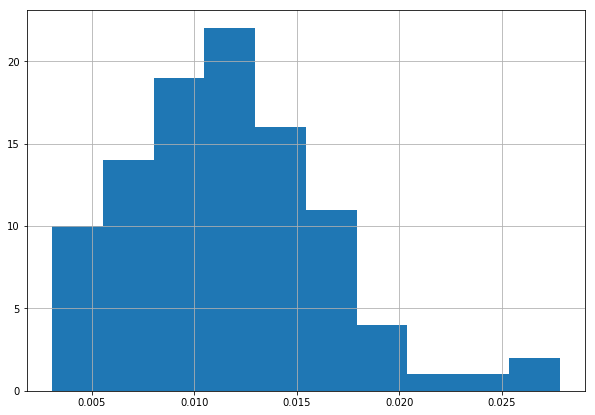

In [7]:
td = model_data.as_test_data_generator(model)
td.on_epoch_end()
td.accuracy["epoch"].hist(figsize=(10, 7))

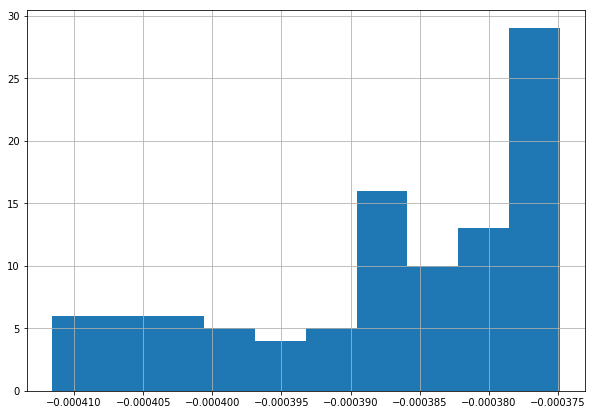